# Import

In [ ]:
import csv
import os
import pickle
import sys
from itertools import product, chain
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

## Add configuration file

In [2]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [3]:
from ALL import config
import MultilayerDict as md
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_error_1_layout import layout
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [5]:
s3 = S3Manager()

In [6]:
sampling_nums = [1, 2, 4, 8, 16, 32, 64, 128]

In [7]:
# data_types = [f"20NewsSampled{sampling_num}" for sampling_num in sampling_nums]
data_types = ["TweetTopic", "TweetFinance"]
vectorize_type = "sentenceBERT"
transformer_models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
]

In [8]:
transformer_model = transformer_models[0]
data_type = data_types[0]

In [9]:
vector_dims = config["vectorize"][vectorize_type][transformer_model]["dims"]
normalizations = config["vectorize"][vectorize_type][transformer_model]["normalization"]
vector_model_nums = config["vectorize"][vectorize_type][transformer_model][
    "max_model_num"
]

model_nums = config["clustering"]["gmm"]["max_model_num"]
covariance_types = config["clustering"]["gmm"]["covariance_types"]
topic_nums = {
    data_type: config["data"][data_type_classifier(data_type)]["class_num"]
    for data_type in data_types
}
depression_type = "umap"

In [10]:
stats_vals = ["aic", "bic", "mi", "logl"]

In [11]:
names_keys = {"stats": ["aic", "bic", "mi", "logl"]}

# Read data

In [16]:
if vectorize_type == "doc2vec":
    dist_base_paths = [
        f"Postprocessing/{data_type}/{vectorize_type}/GMM/dist"
        for data_type in data_types
    ]
elif vectorize_type == "sentenceBERT":
    dist_base_paths = [
        [
            f"Postprocessing/{data_type}/{vectorize_type}/{transformer_model}/GMM/dist"
            for data_type in data_types
        ]
        for transformer_model in transformer_models
    ]
else:
    raise NotImplementedError

In [17]:
dist_base_paths

[['Postprocessing/TweetTopic/sentenceBERT/sentence-transformers/all-MiniLM-L6-v2/GMM/dist',
  'Postprocessing/TweetFinance/sentenceBERT/sentence-transformers/all-MiniLM-L6-v2/GMM/dist'],
 ['Postprocessing/TweetTopic/sentenceBERT/sentence-transformers/all-mpnet-base-v2/GMM/dist',
  'Postprocessing/TweetFinance/sentenceBERT/sentence-transformers/all-mpnet-base-v2/GMM/dist'],
 ['Postprocessing/TweetTopic/sentenceBERT/sentence-transformers/all-distilroberta-v1/GMM/dist',
  'Postprocessing/TweetFinance/sentenceBERT/sentence-transformers/all-distilroberta-v1/GMM/dist']]

In [18]:
with ThreadPoolExecutor(max_workers=15) as executor:
    f = []
    for dist_base_path in list(chain.from_iterable(dist_base_paths)):
        f.append(executor.submit(s3.download, dist_base_path))
    for f in tqdm(as_completed(f), total=len(f)):
        pass  # 処理終了を待つ

100%|██████████| 6/6 [04:09<00:00, 41.55s/it] 


In [ ]:
dists = []
keys = []
for data_type in data_types:
    for (
        transformer_model,
        vector_dim,
        normalization,
        vector_model_num,
        covariance_type,
        topic_num,
        model_num,
    ) in tqdm(
        list(
            product(
                transformer_models,
                vector_dims,
                normalizations,
                range(vector_model_nums),
                covariance_types,
                topic_nums[data_type],
                range(model_nums),
            )
        )
    ):
        dist_base_path = (
            f"Postprocessing/{data_type}/{vectorize_type}/{transformer_model}/GMM/dist"
        )
        stats_file_path = f"/{vector_dim}/{normalization}/{vector_model_num}/{covariance_type}/{topic_num}/{model_num}.npy"
        dist_path = f"{root_path_temporary}{dist_base_path}{stats_file_path}"

        dist = np.load(dist_path)
        dists.append(dist)
        keys.append(
            [
                data_type,
                transformer_model,
                vector_dim,
                normalization,
                vector_model_num,
                covariance_type,
                model_num,
            ]
        )

 56%|█████▌    | 1403/2520 [00:35<01:14, 15.09it/s]

In [26]:
multi_d = md.MultilayerDict(
    names_keys={
        "data_type": data_types,
        "transformer_model": transformer_models,
        "vector_dim": vector_dims,
        "normalization": normalizations,
        "vector_model_num": range(vector_model_nums),
        "covariance_type": covariance_types,
        "model_num": range(model_nums),
    }
)

In [27]:
multi_d = multi_d.extend(keys, dists)

In [ ]:
# lda_mi = pd.read_csv(f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0)

In [ ]:
# describe_lda_mi, _ = get_describe(lda_mi, axis=0)

# Data shaping

In [28]:
multi_d = md.swap_keys(
    multi_d,
    [
        "data_type",
        "transformer_model",
        "vector_dim",
        "normalization",
        "vector_model_num",
        "covariance_type",
        "stats",
        "model_num",
    ],
)

In [29]:
def get_keys(names: List, names_keys:Dict)->List:
    return [names_keys[name] for name in names]

In [30]:
keys = get_keys(
    [
        "data_type",
        "transformer_model",
        "vector_dim",
        "normalization",
        "vector_model_num",
        "covariance_type",
    ],
    multi_d.names_keys,
)

In [31]:
for key in product(*keys):
    df = pd.DataFrame(multi_d.loc(key), dtype="float64")
    multi_d.update(key, df)

In [32]:
multi_d = multi_d.drop_names(names=["stats", "model_num"])

In [33]:
for key in product(*keys):
    describe, desciribe_key = get_describe(multi_d.loc(key), axis=0, return_dict=True)
    multi_d.update(key, describe)

In [34]:
multi_d = multi_d.add_names({"agg_type":['mean', 'median', 'std', 'var', '75', '25'], "stats": stats_vals})

In [35]:
covariance_d = md.swap_keys(
    multi_d,
    [
        "data_type",
        "transformer_model",
        "normalization",
        "vector_model_num",
        "stats",
        "agg_type",
        "vector_dim",
        "covariance_type",
    ],
)

In [36]:
keys = get_keys(
    [
        "data_type",
        "transformer_model",
        "normalization",
        "vector_model_num",
        "stats",
    ],
    covariance_d.names_keys,
)

In [37]:
for key in product(*keys):
    df = pd.DataFrame(covariance_d.loc(key)["mean"])
    covariance_d.update(key, df)

In [38]:
covariance_d = covariance_d.drop_names(["agg_type", "vector_dim", "covariance_type"])

# Plot

In [39]:
keys = get_keys(
    [
        "data_type",
        "transformer_model",
        "normalization",
        "vector_model_num",
        "stats",
    ],
    covariance_d.names_keys,
)

In [40]:
xlabel="埋め込み次元"
ylabel="mi"
yticks=np.arange(0, 1.1, 0.1)

/tmp/ipykernel_720281/2255602939.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**layout["figure"])


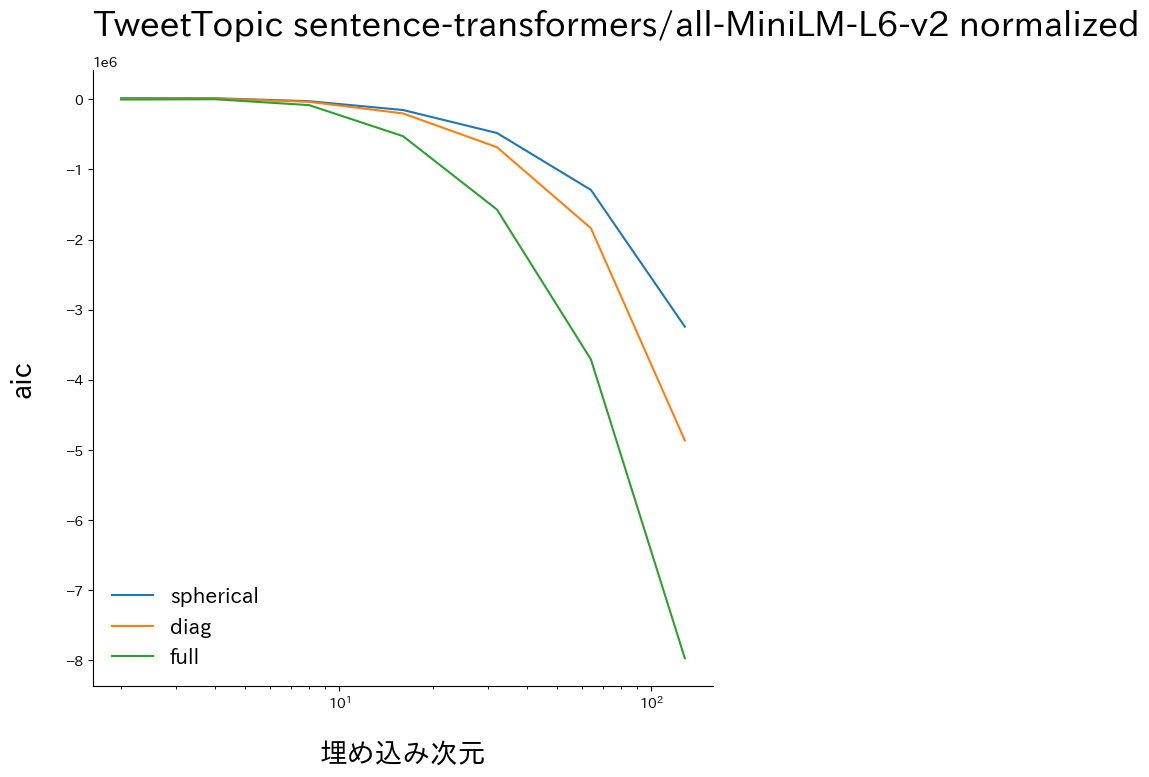

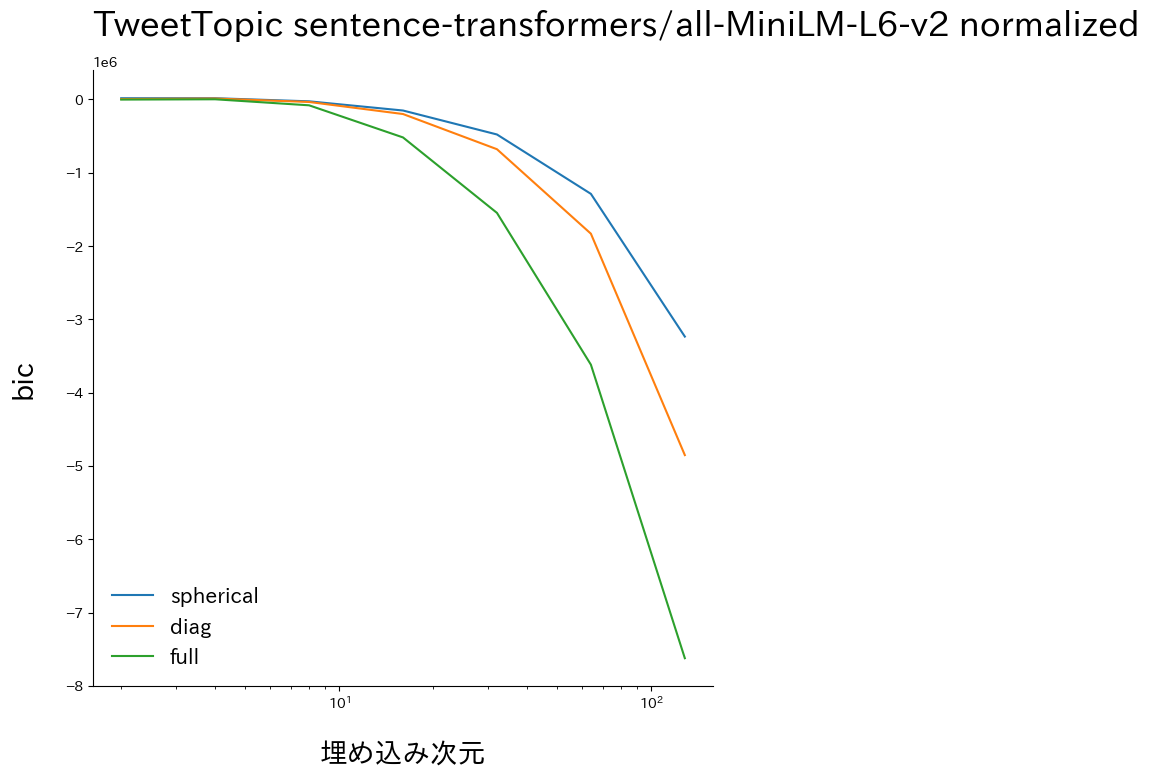

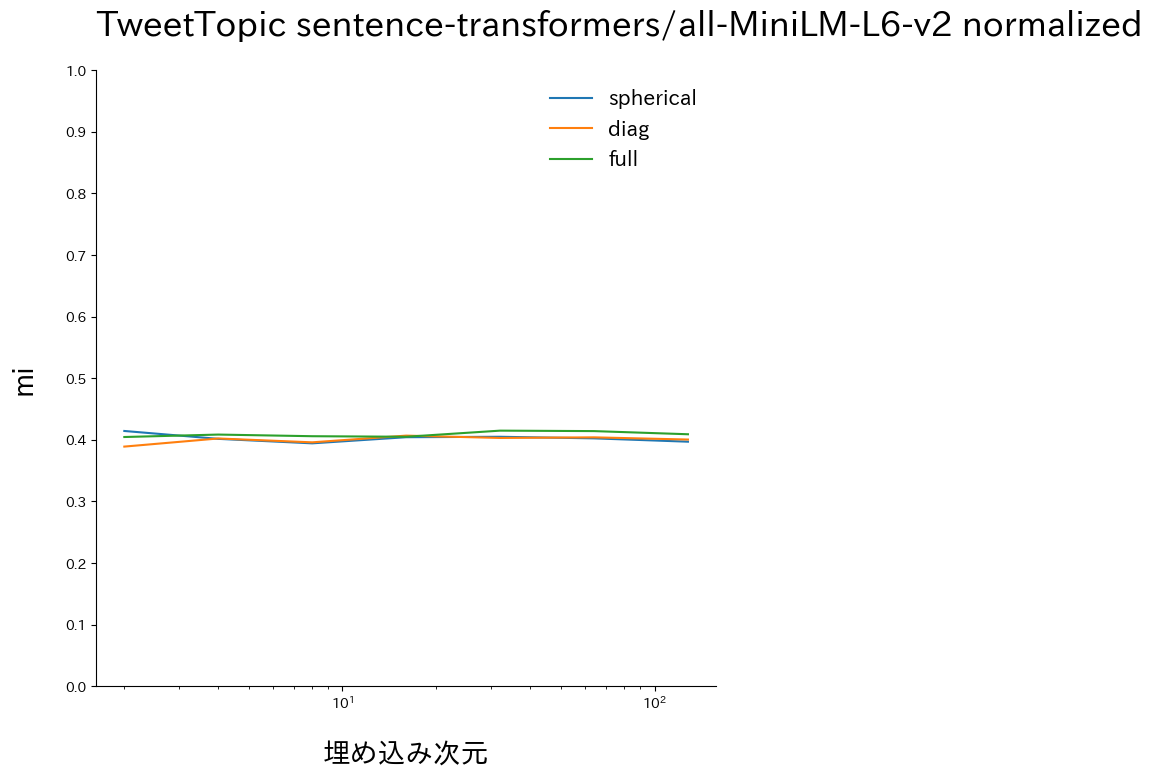

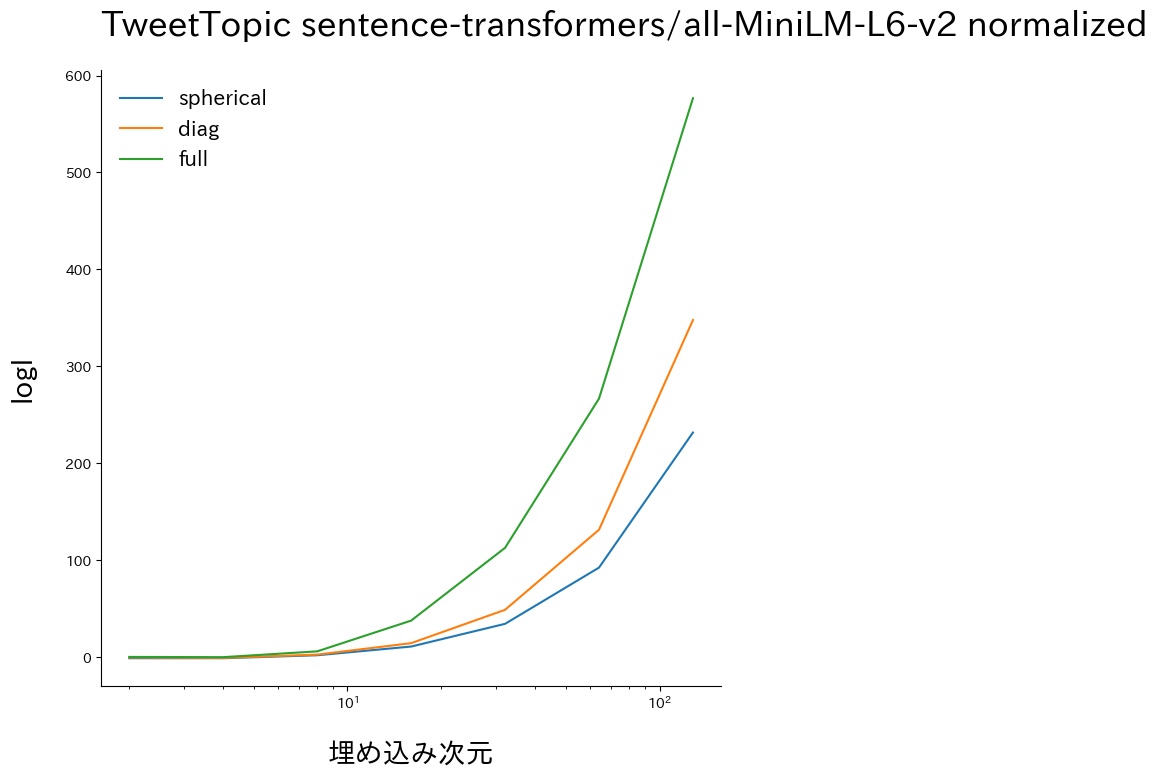

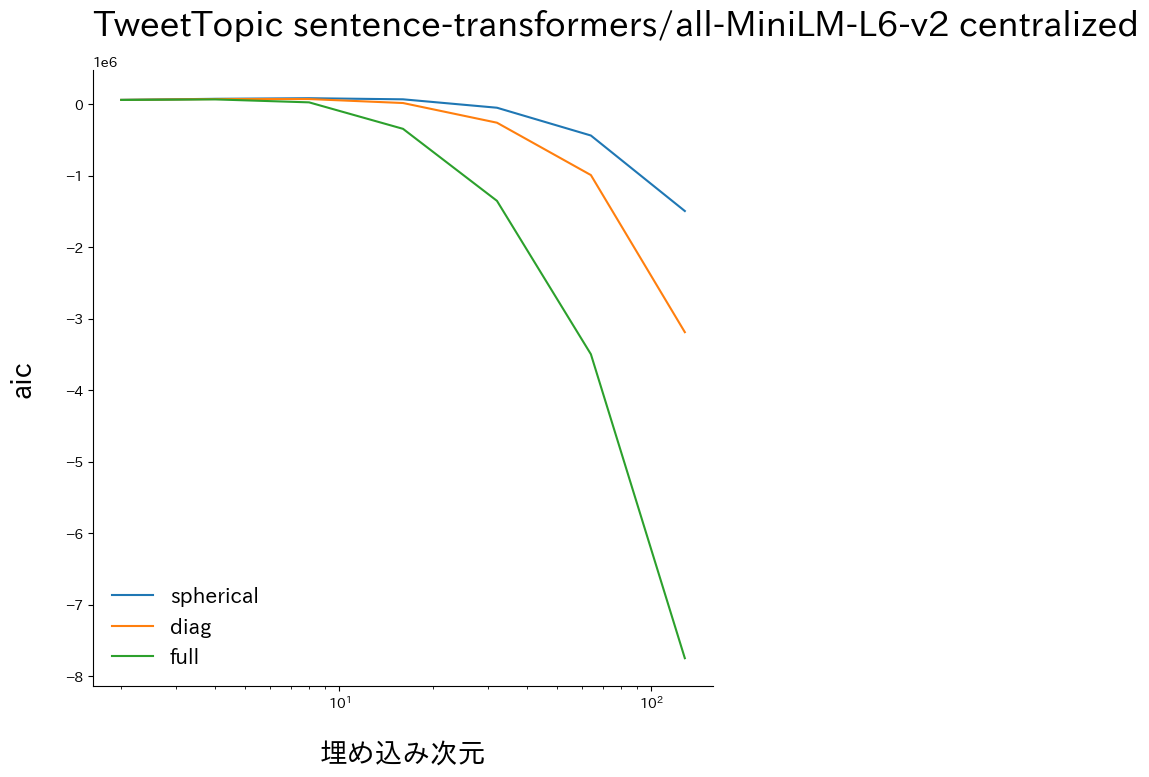

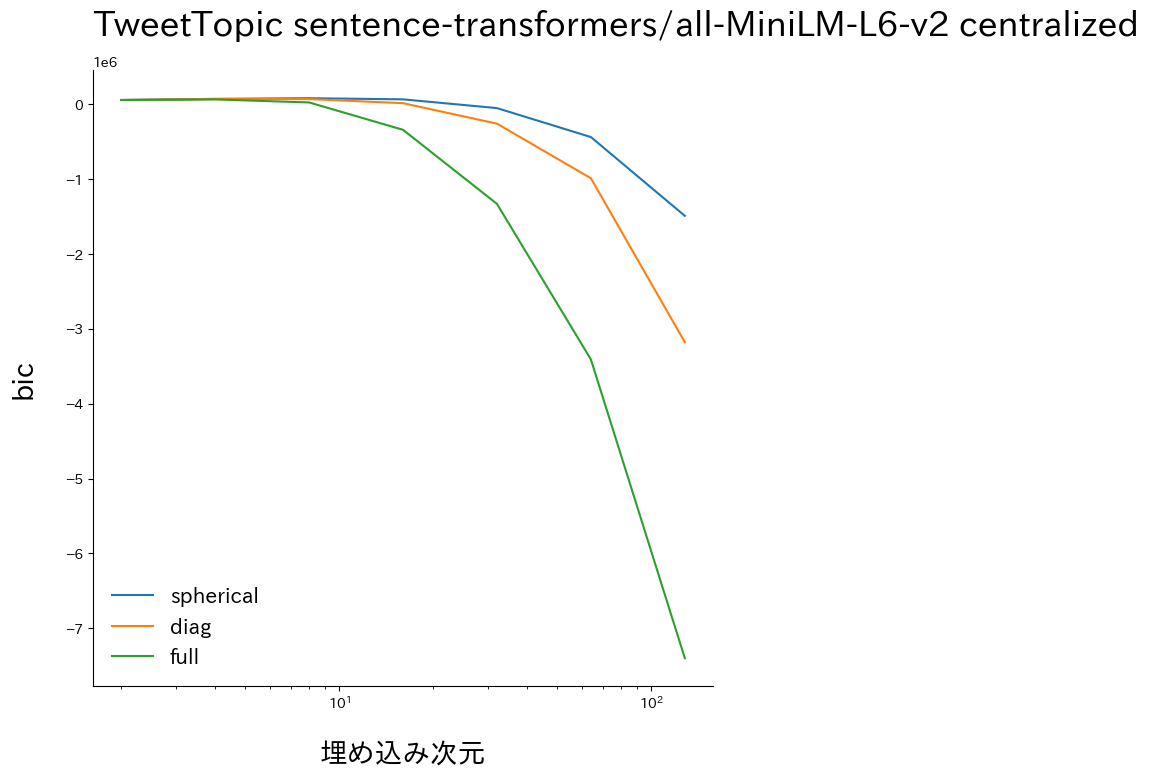

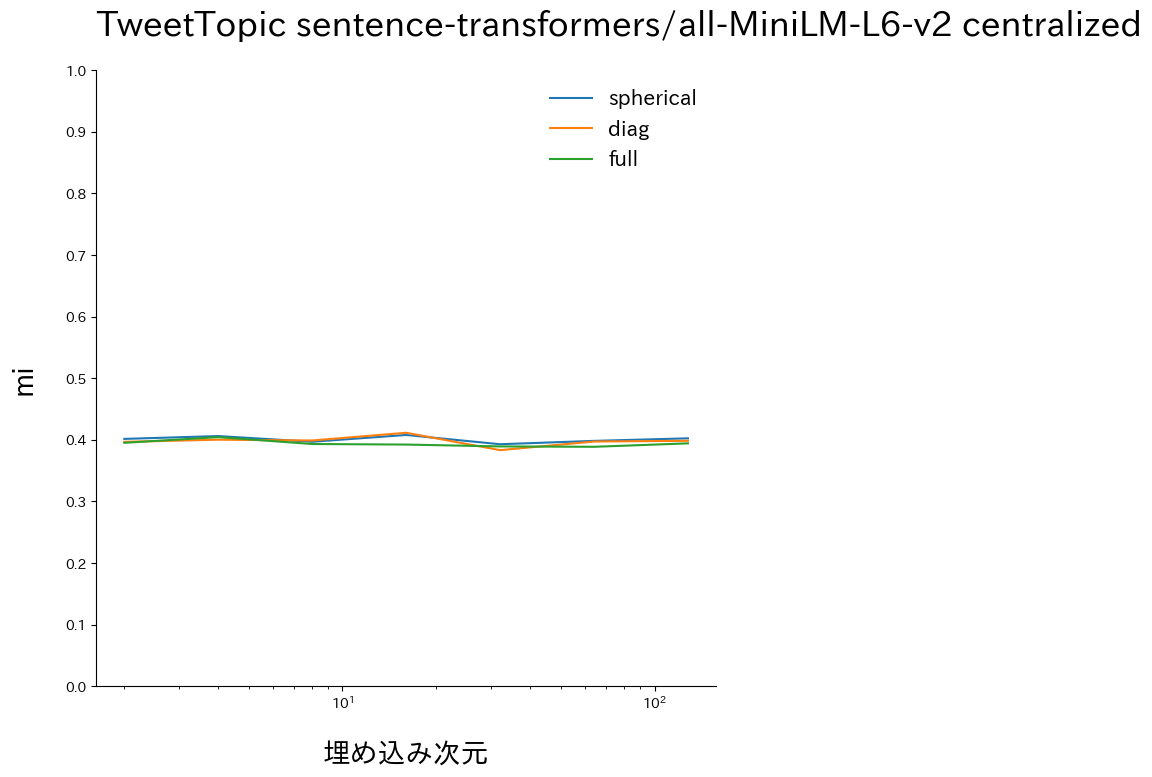

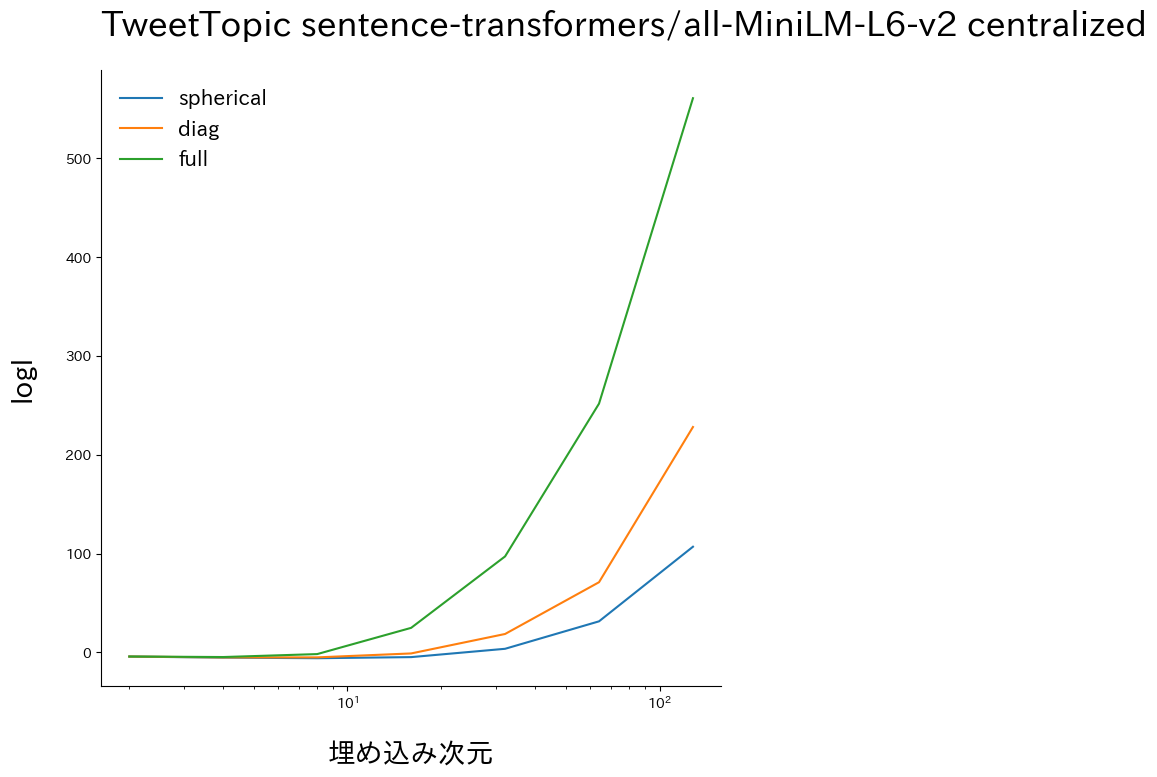

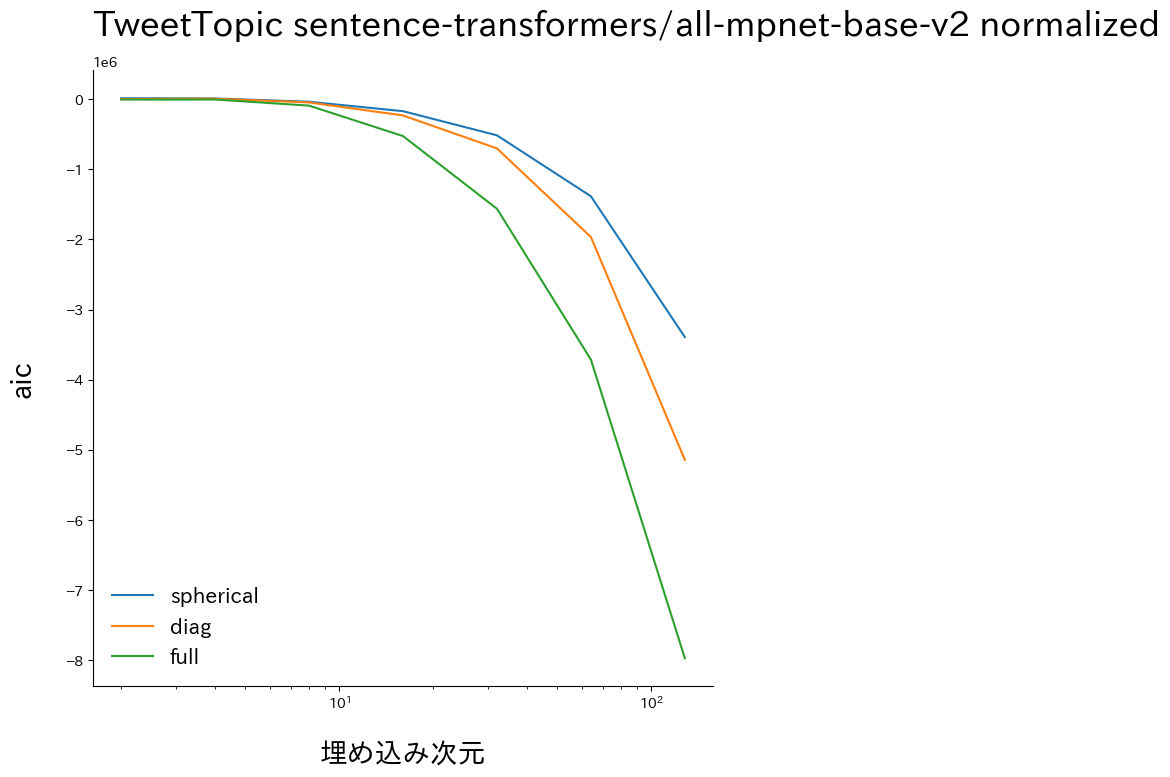

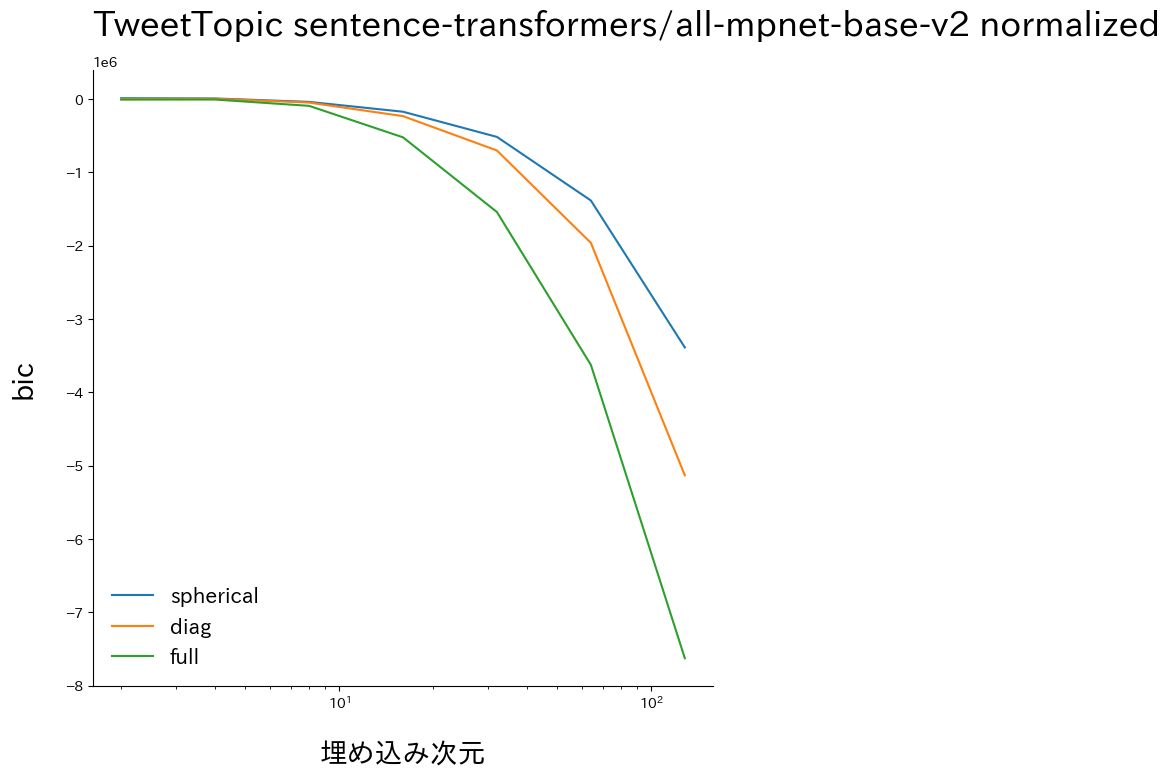

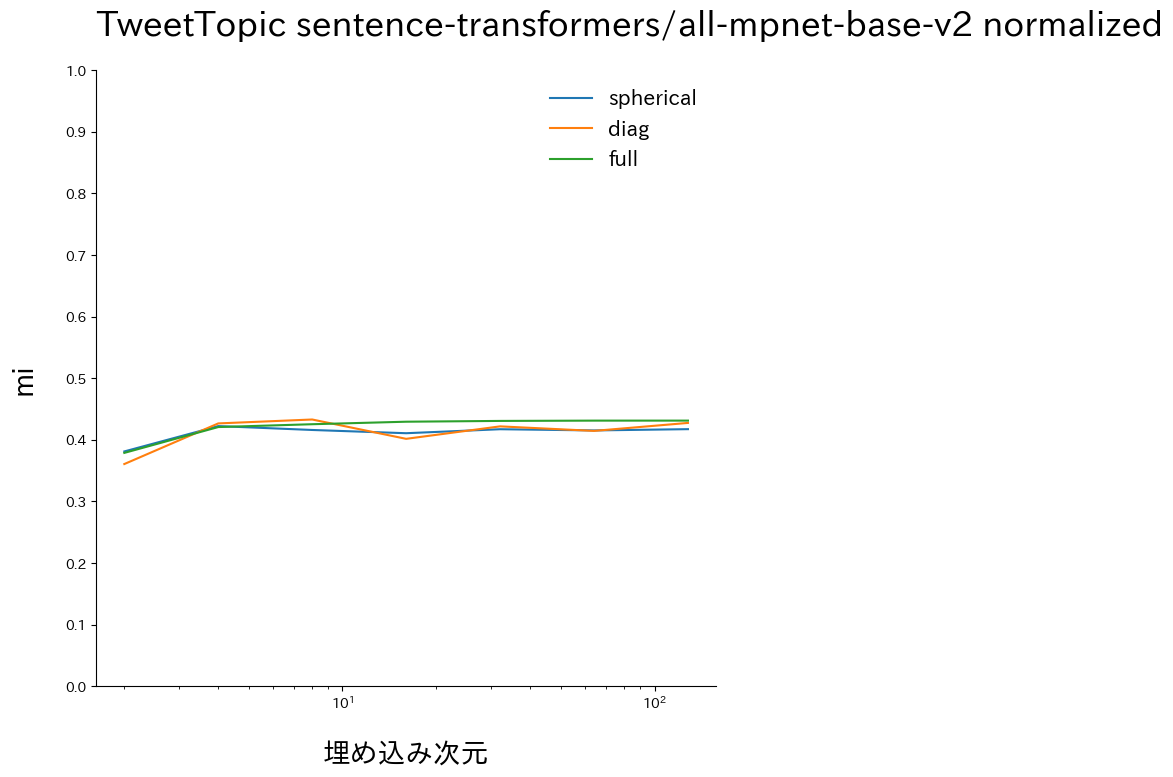

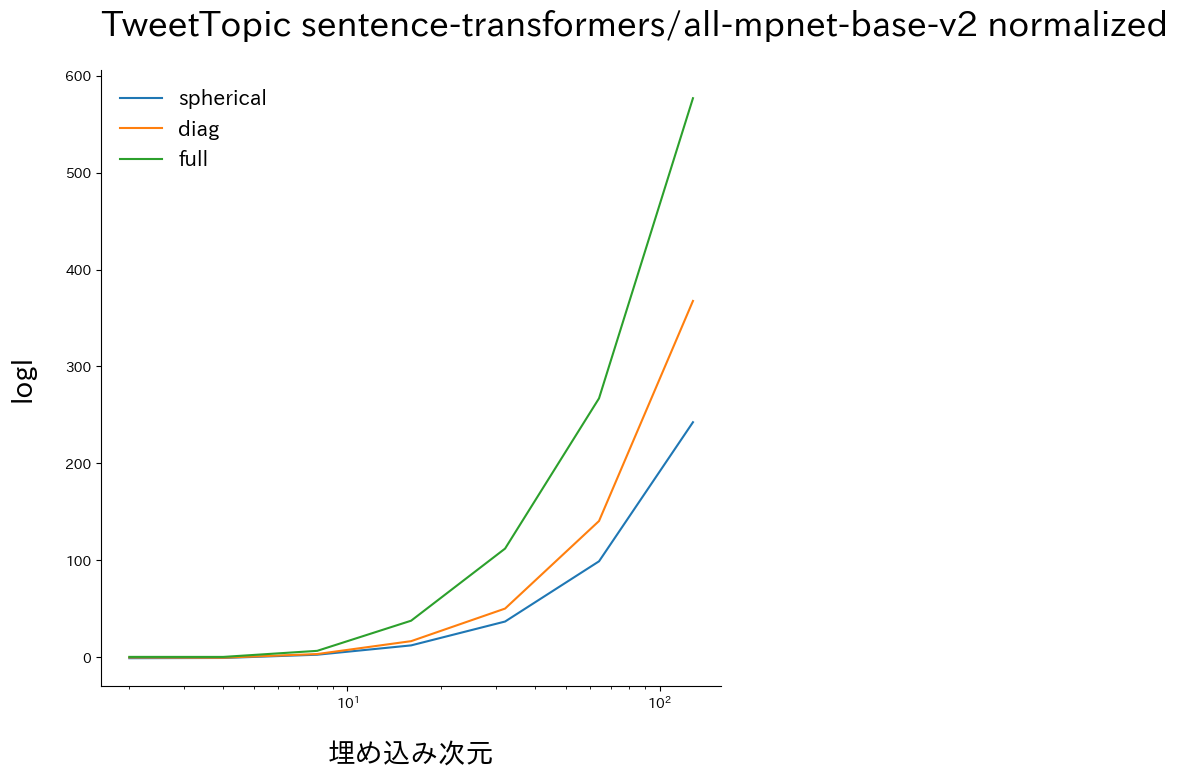

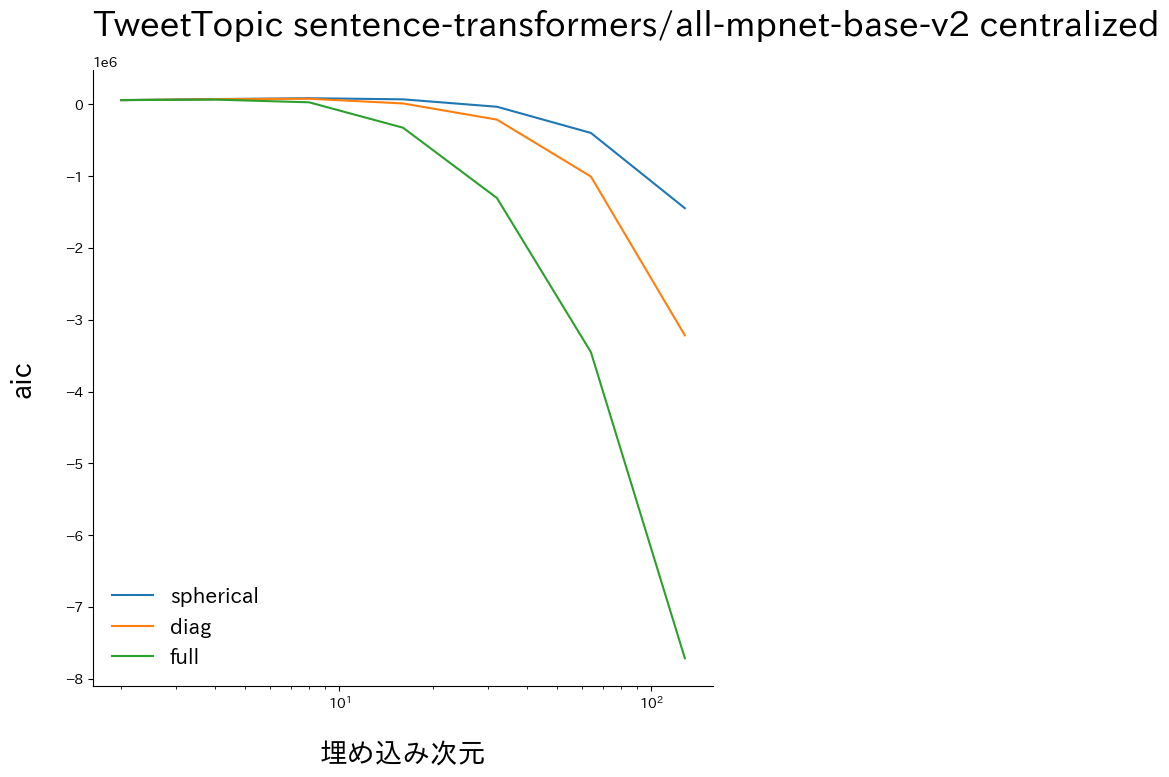

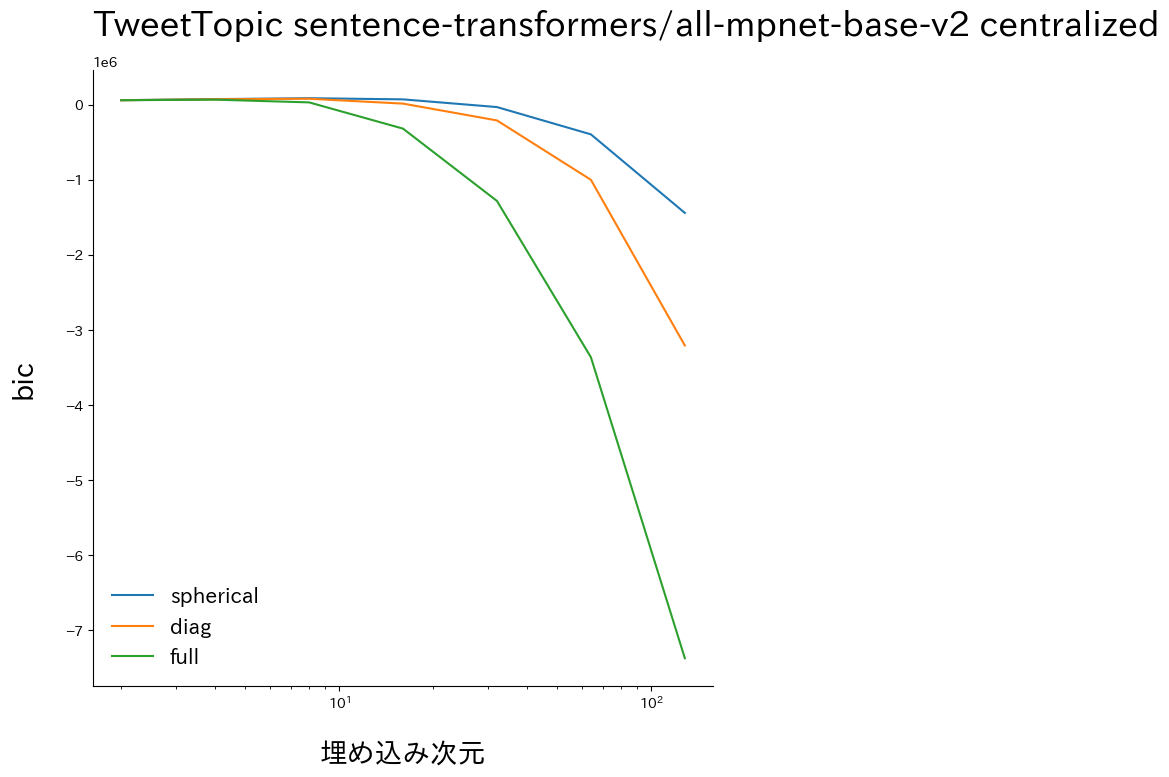

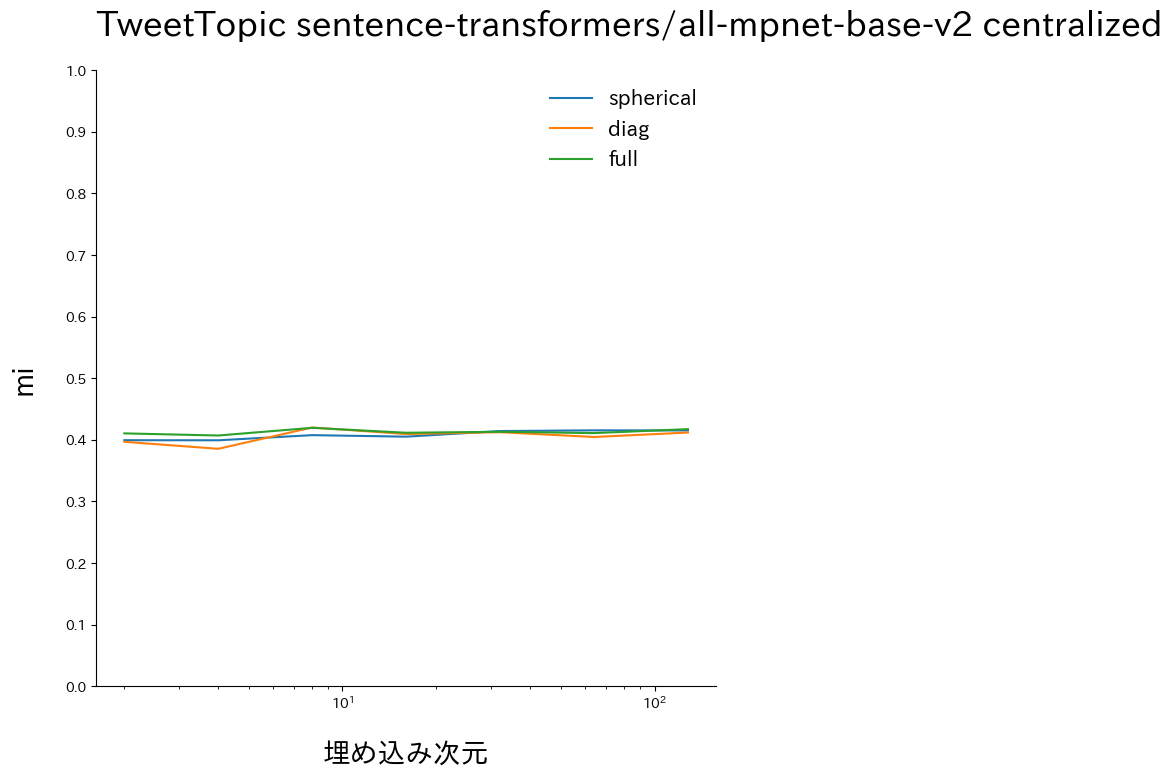

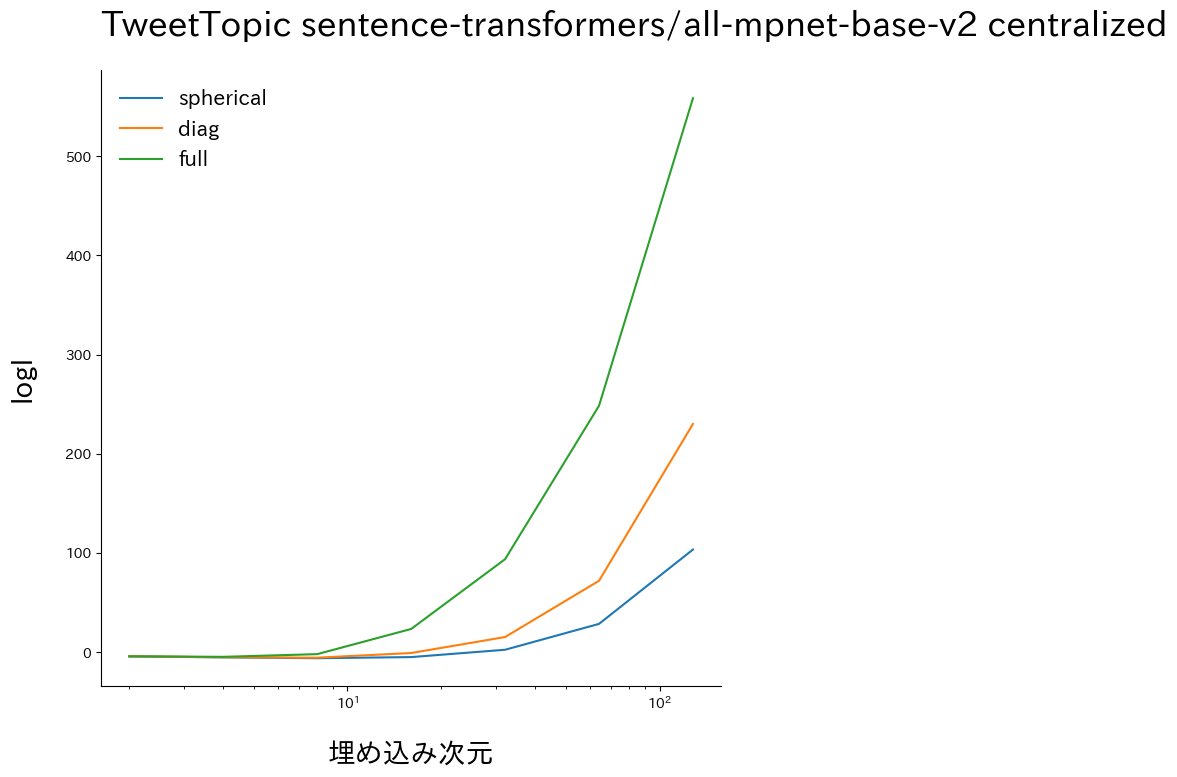

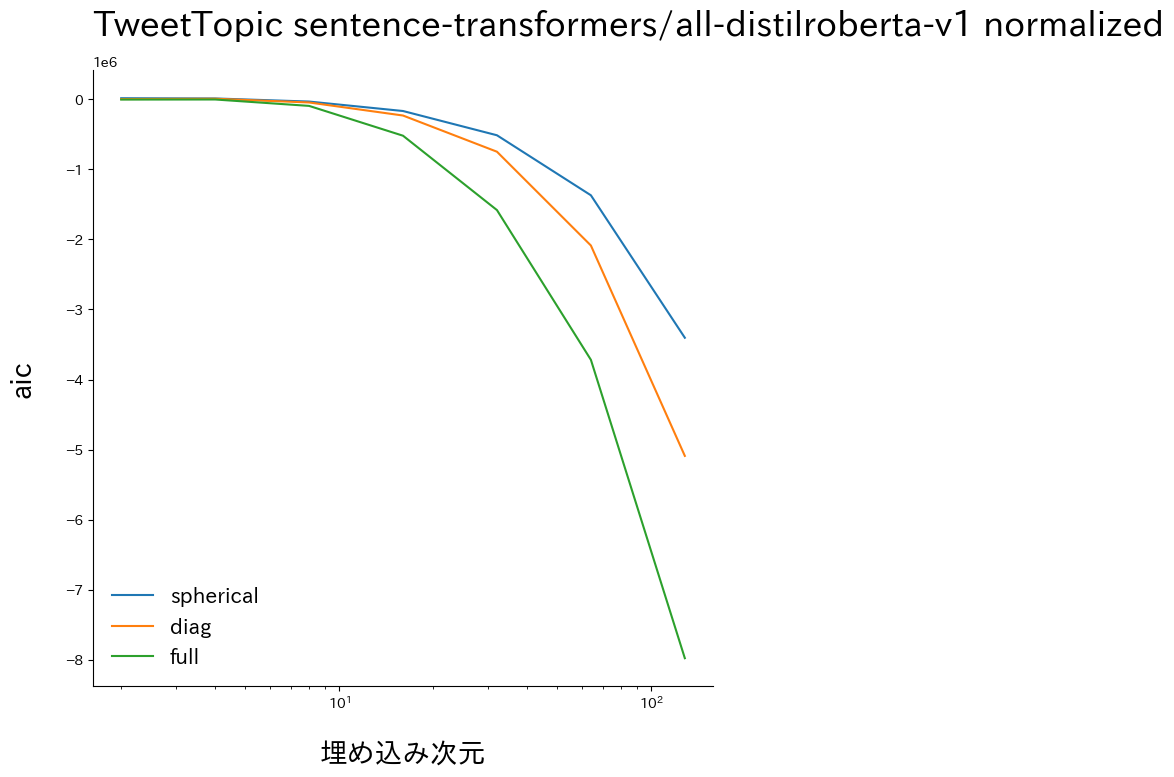

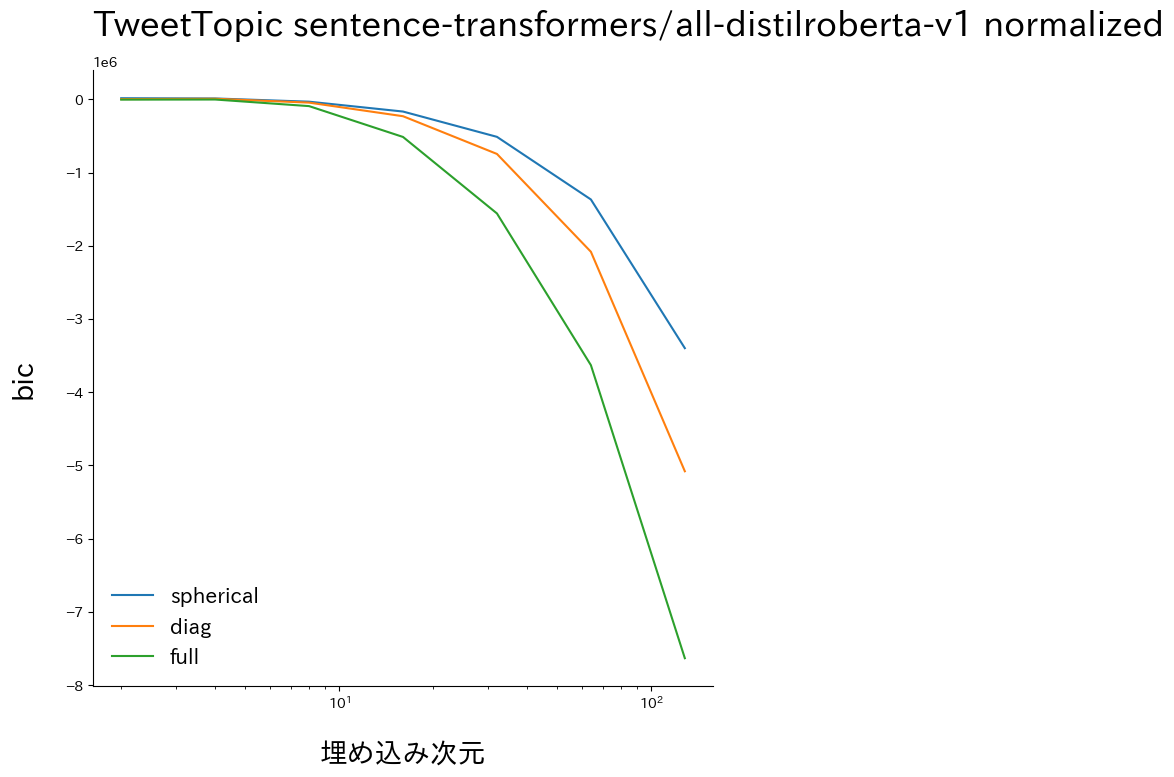

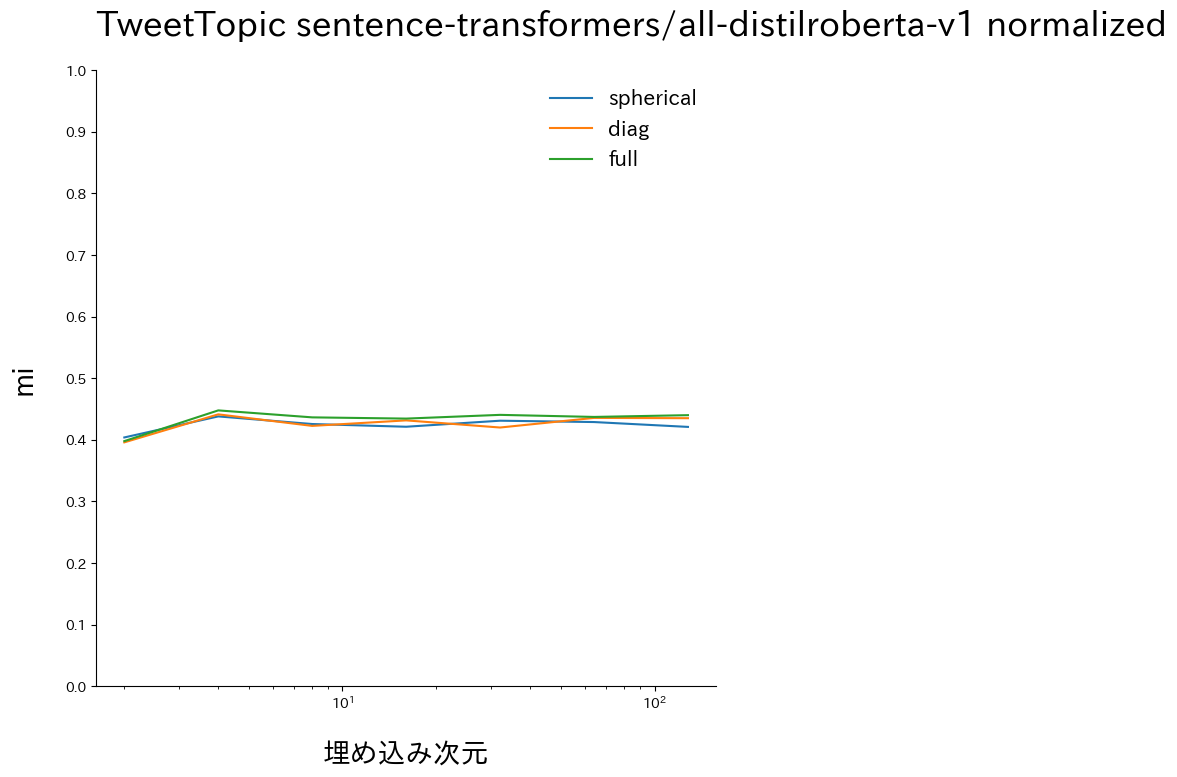

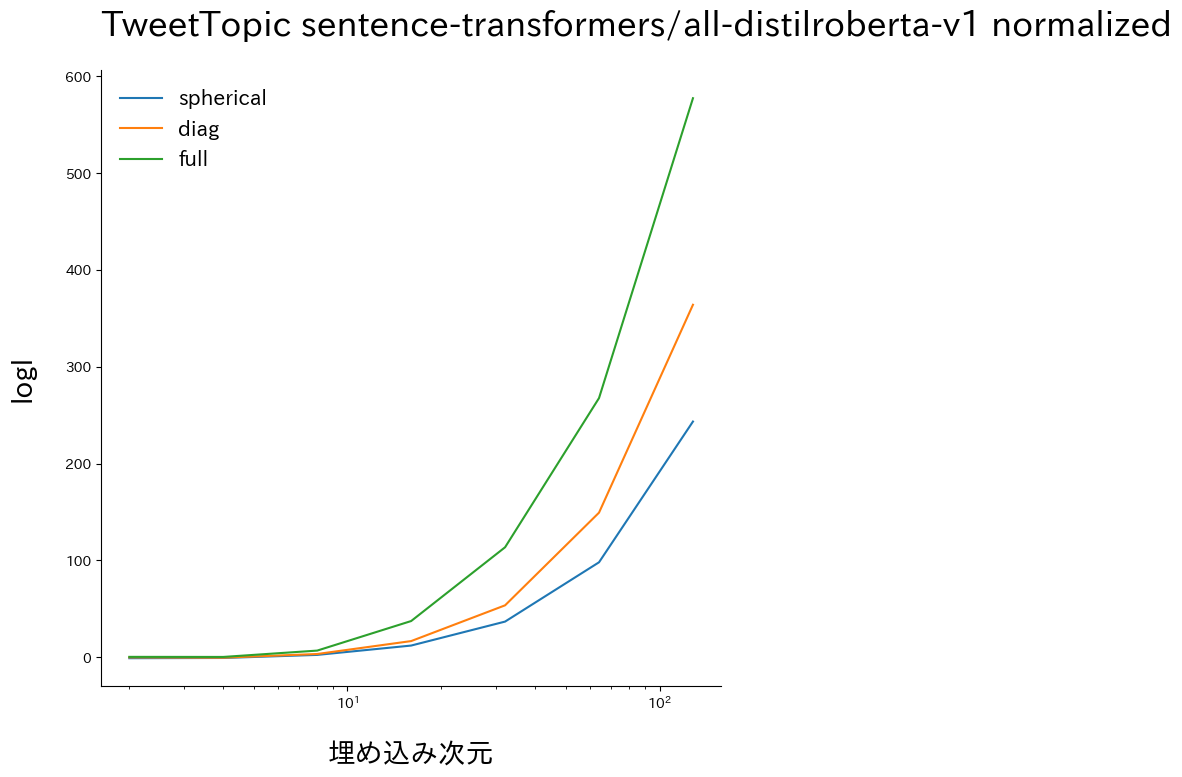

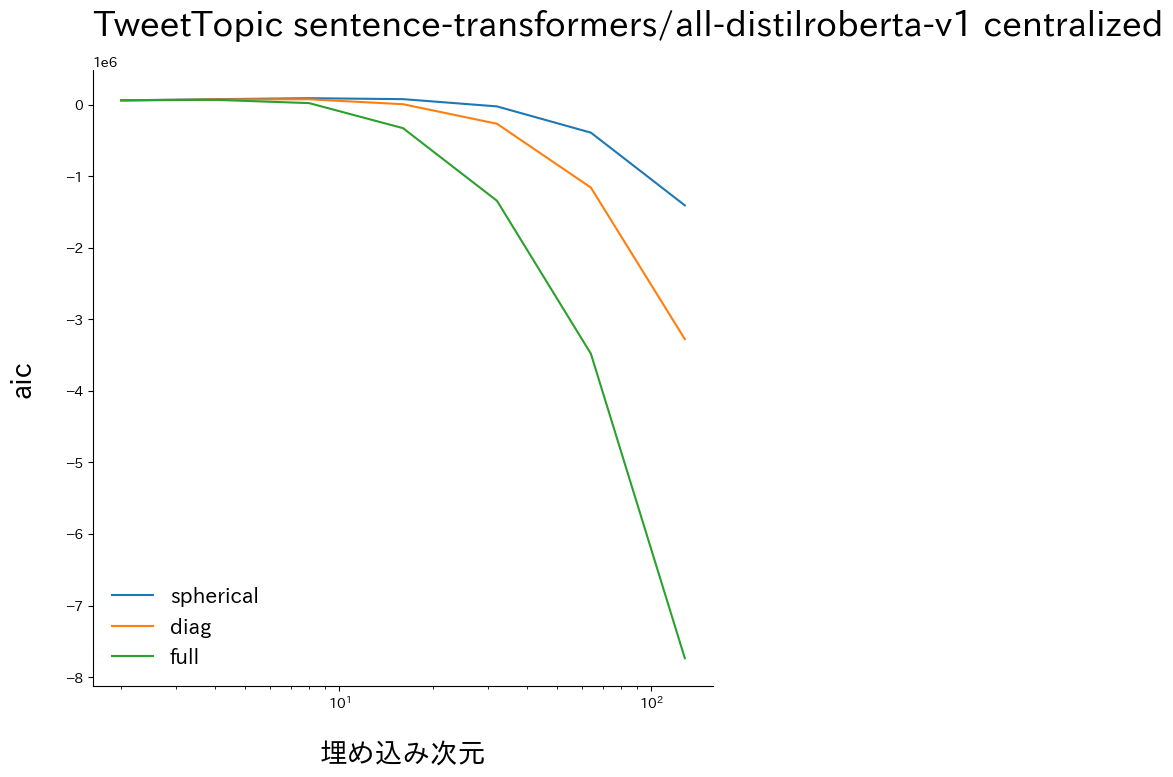

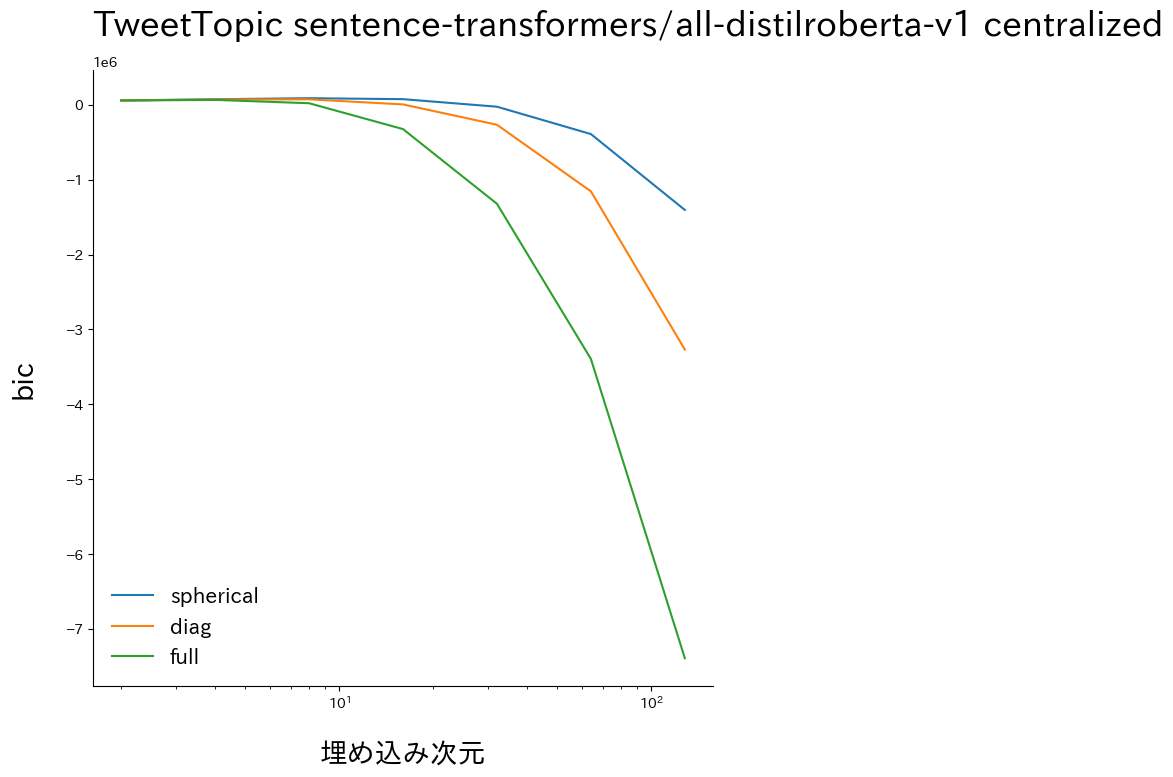

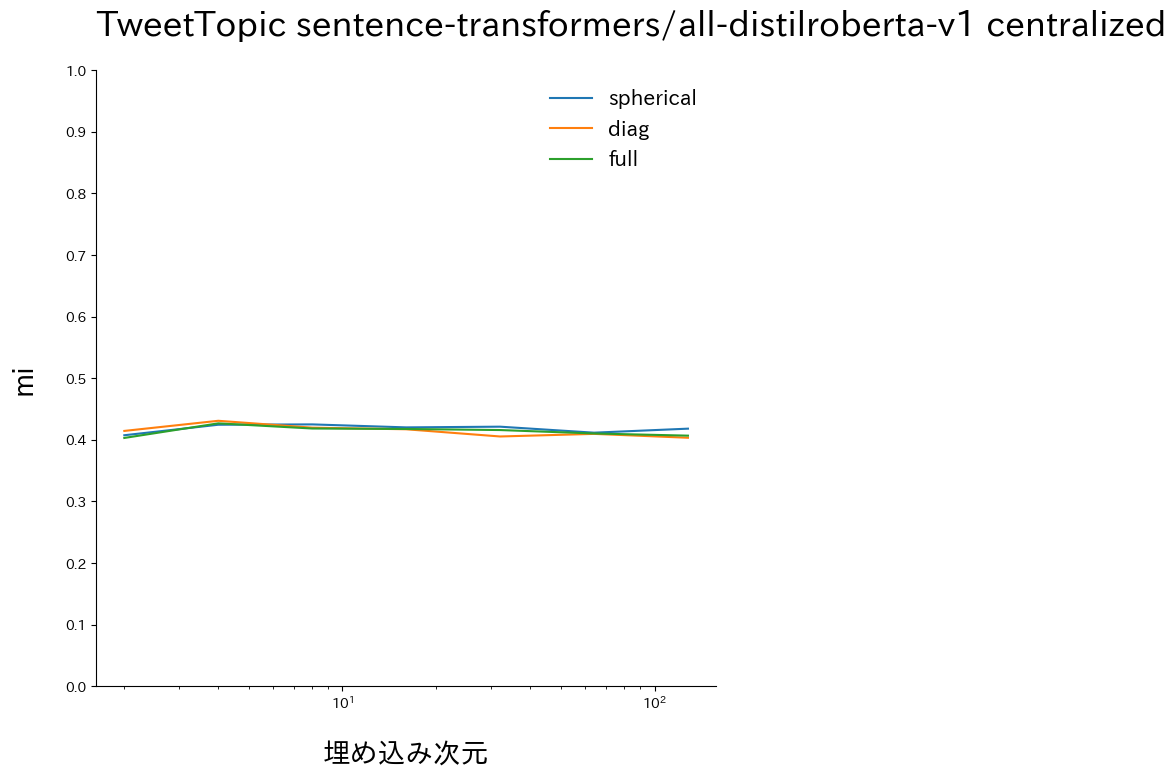

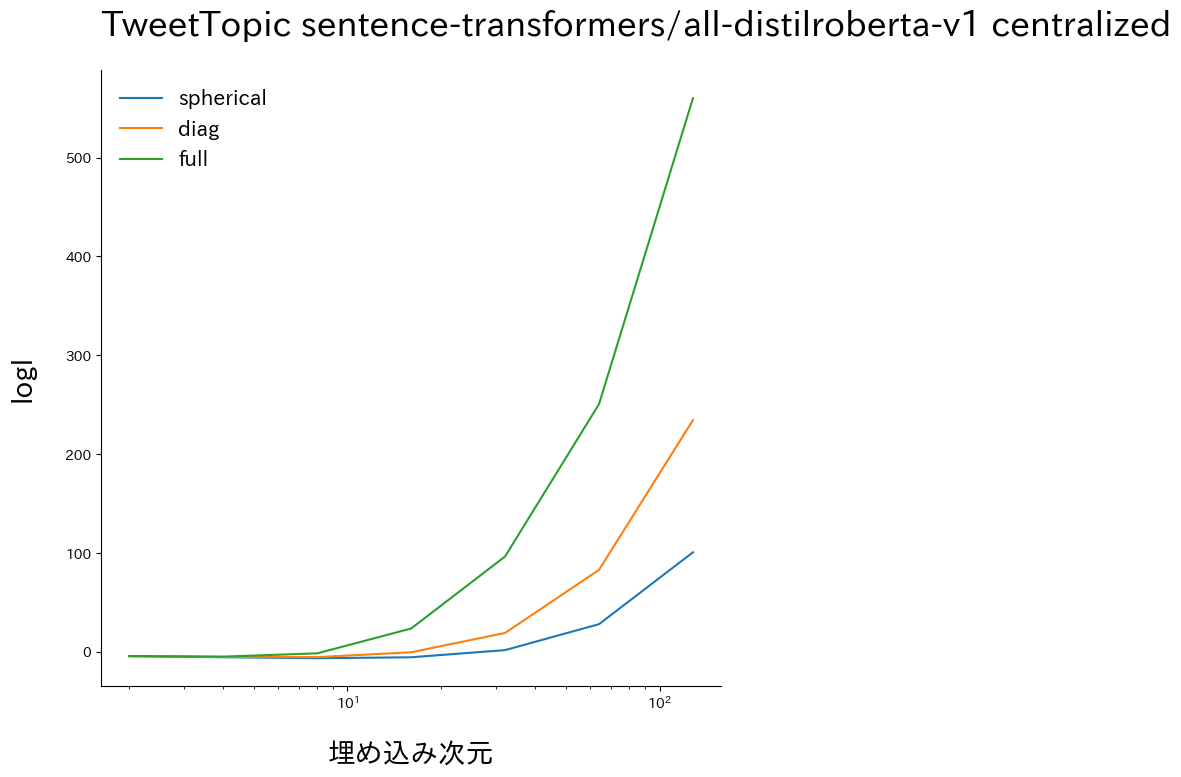

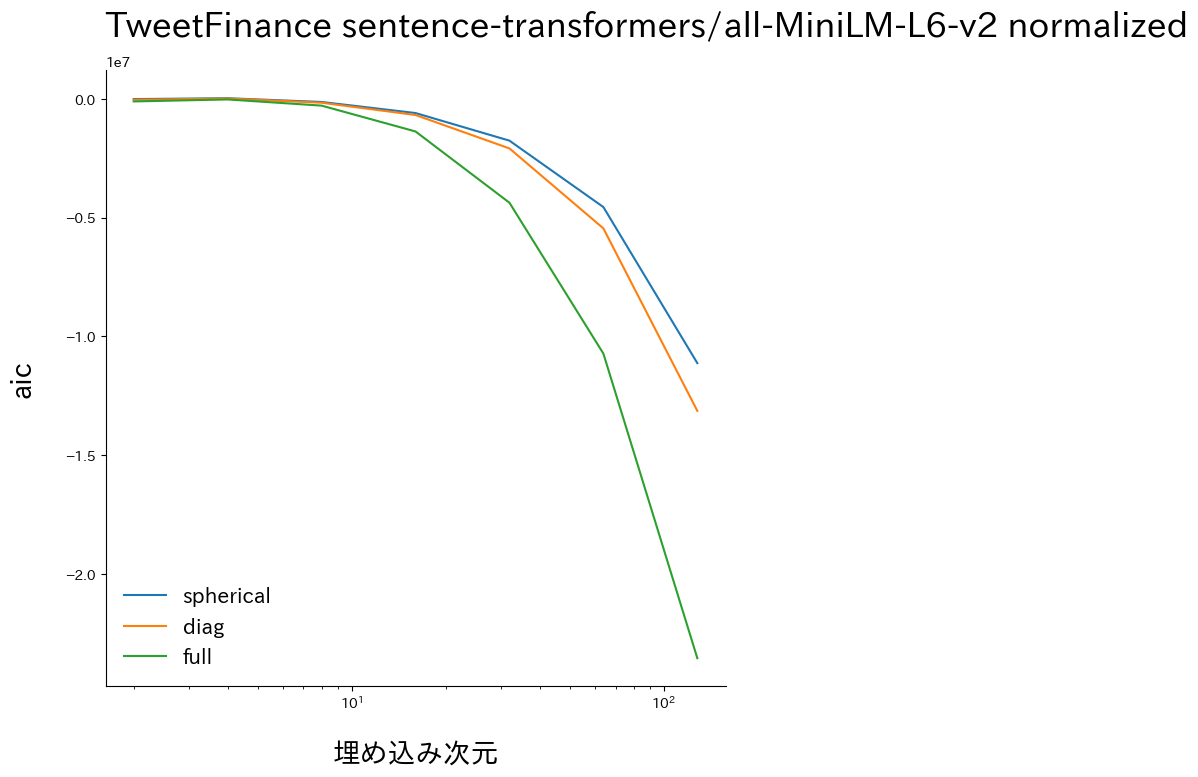

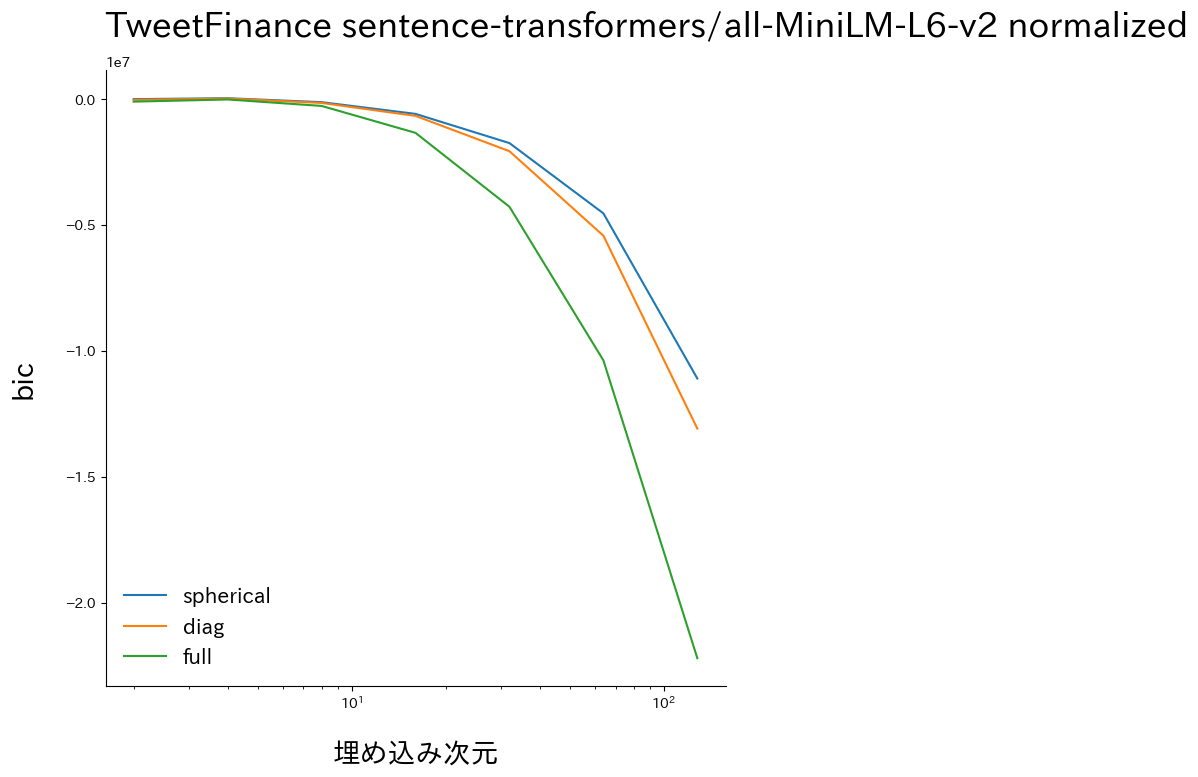

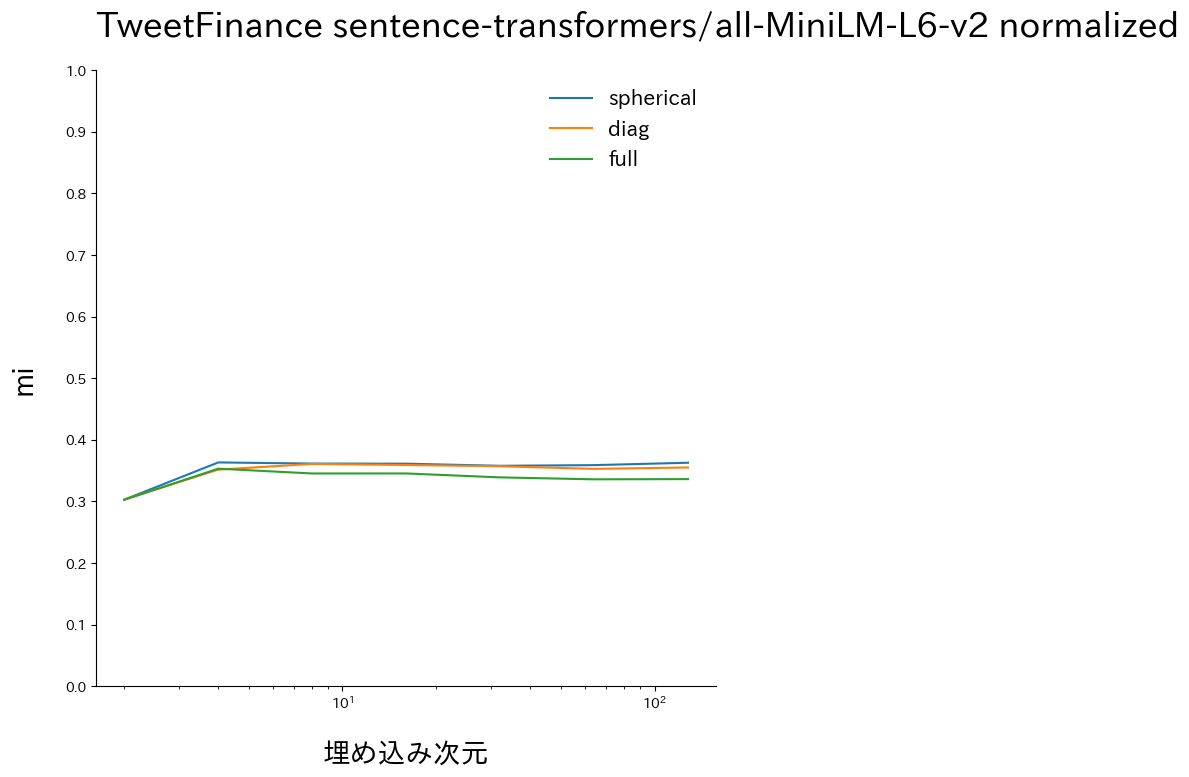

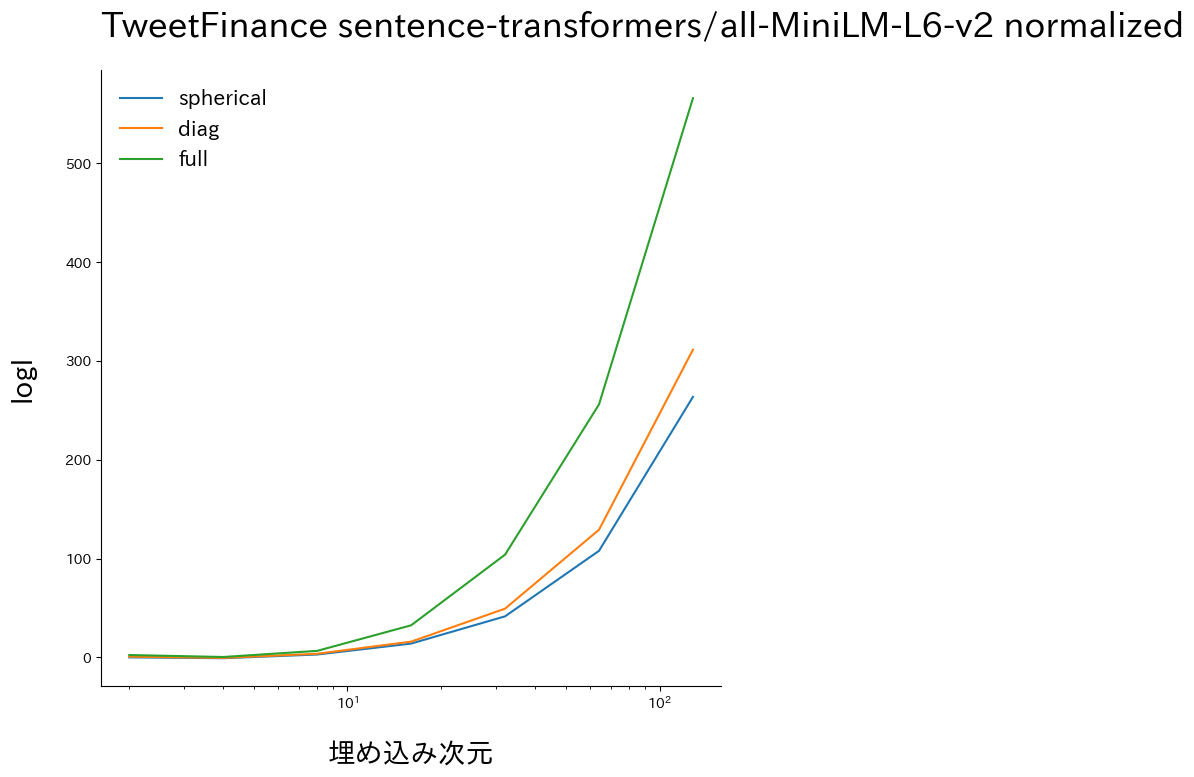

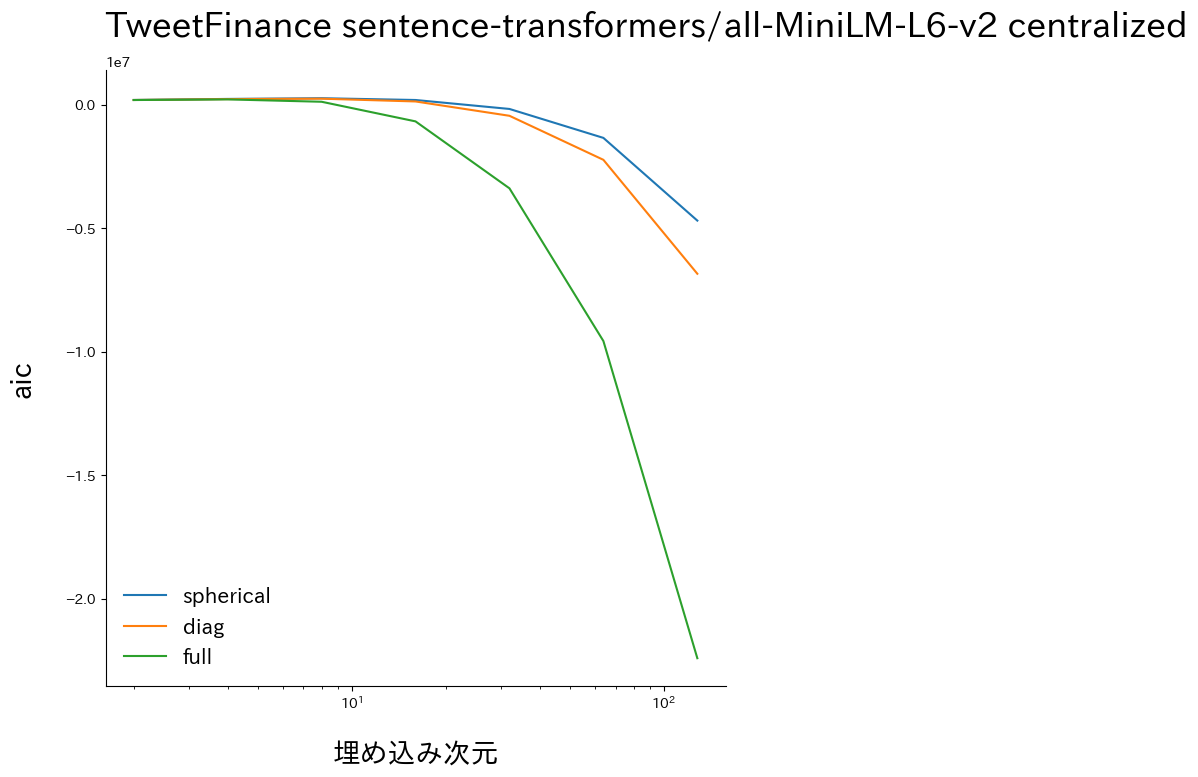

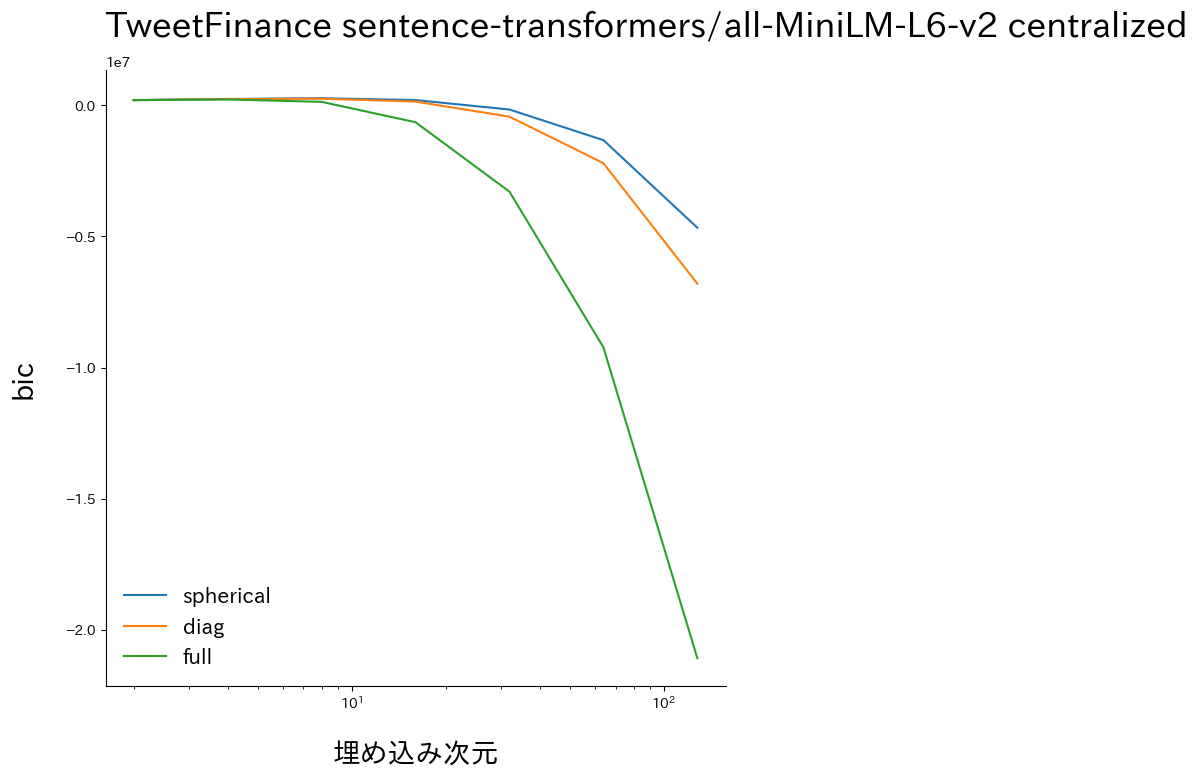

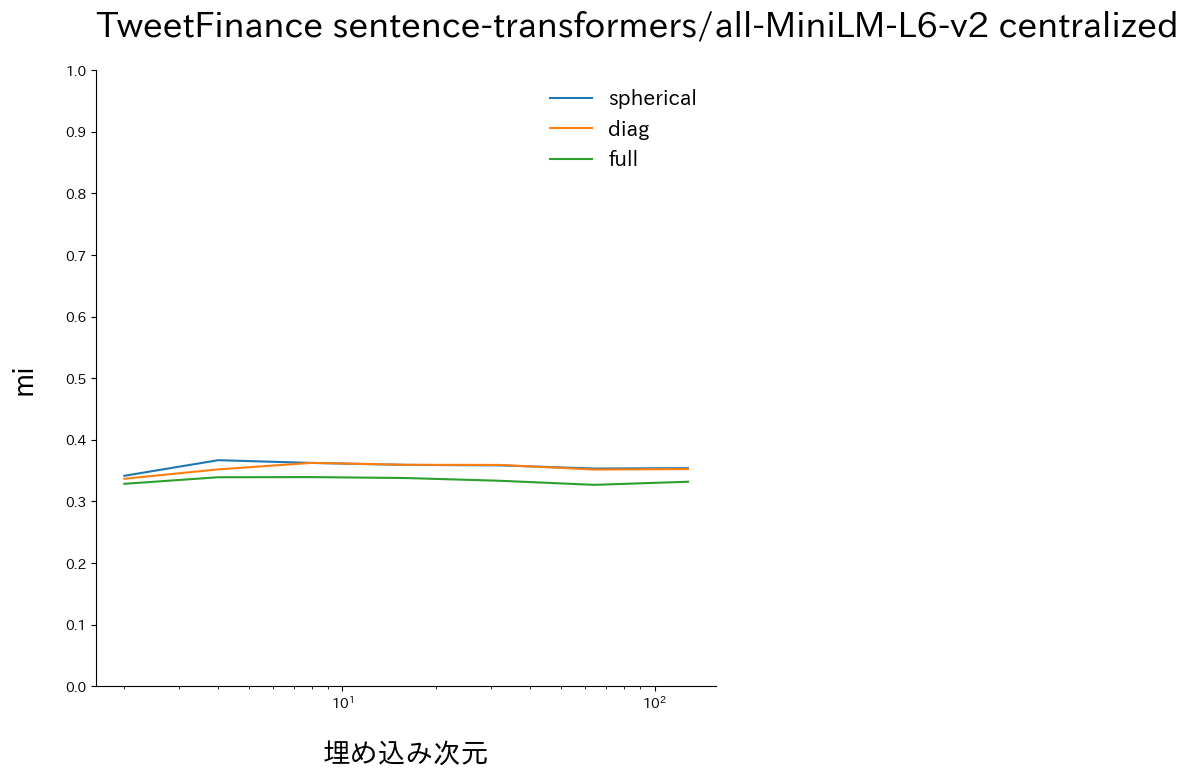

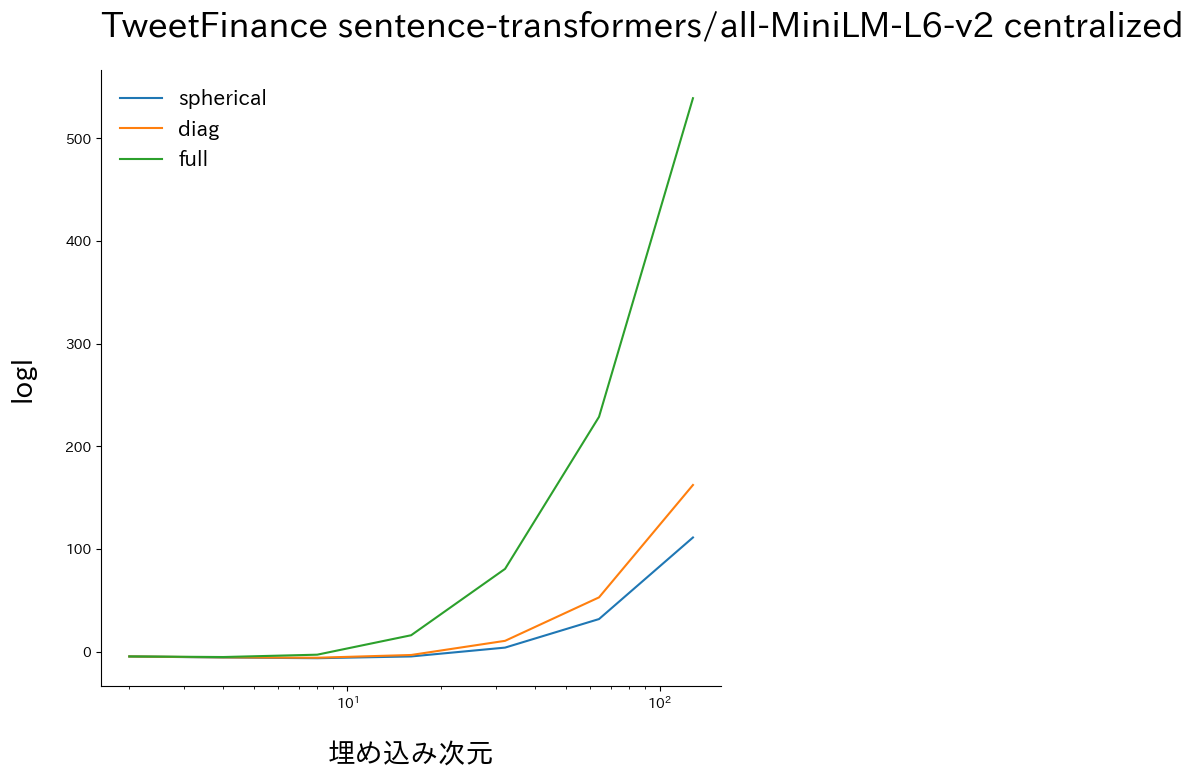

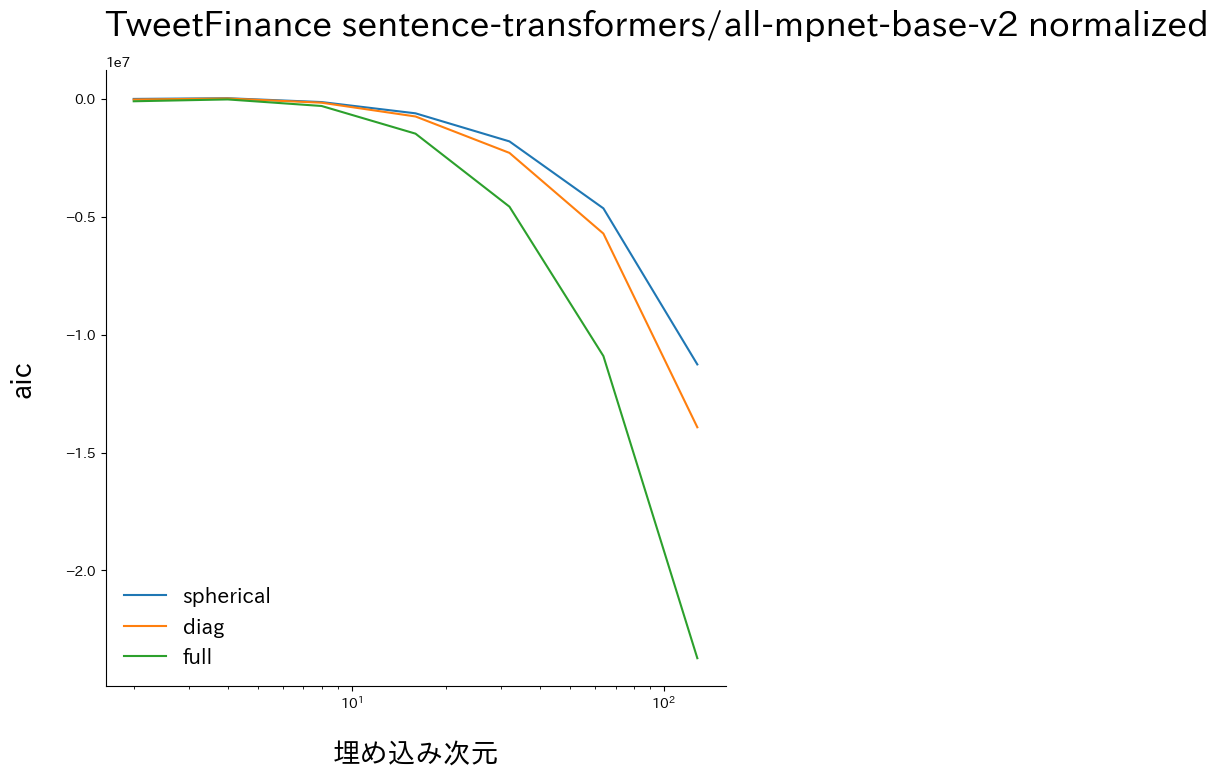

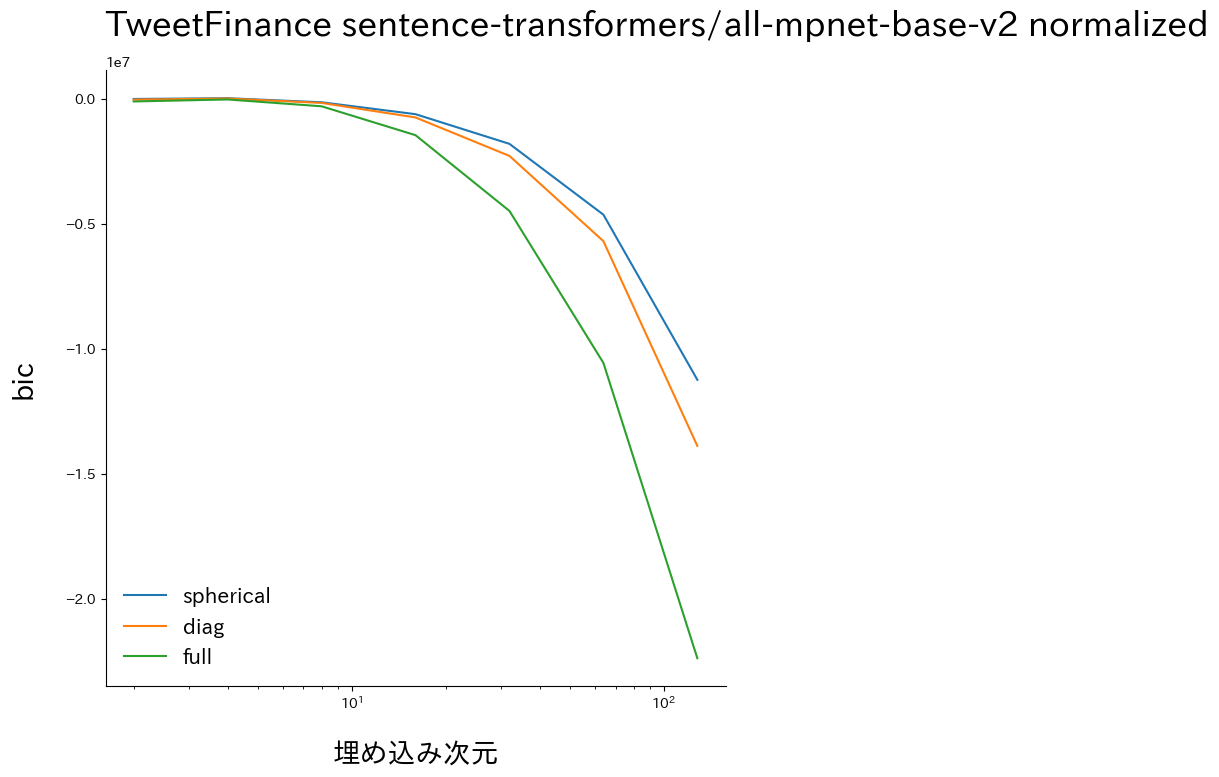

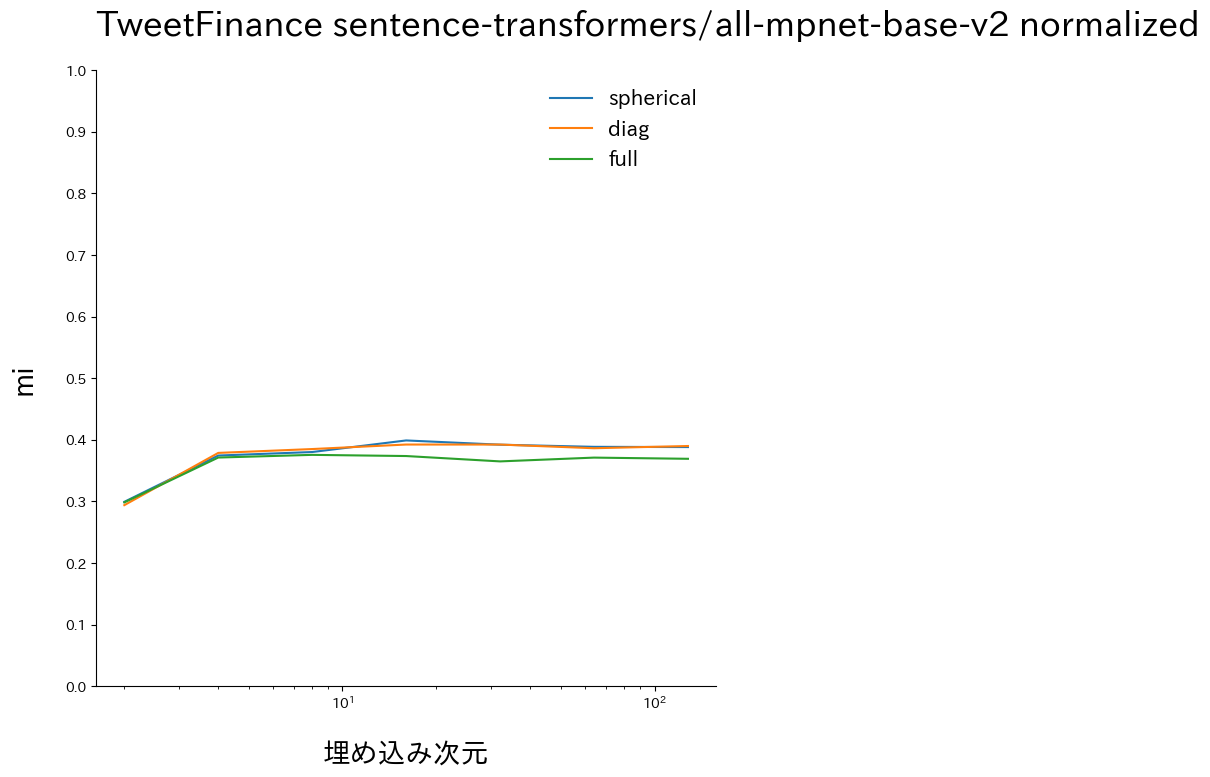

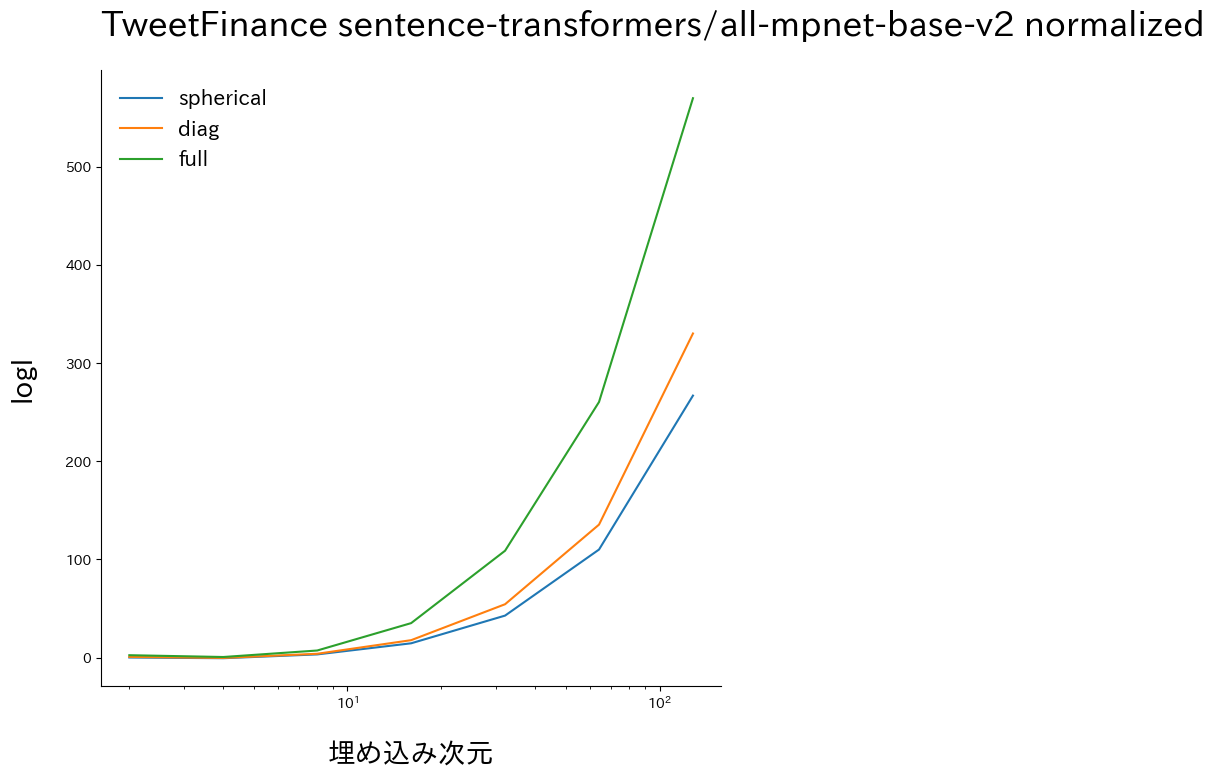

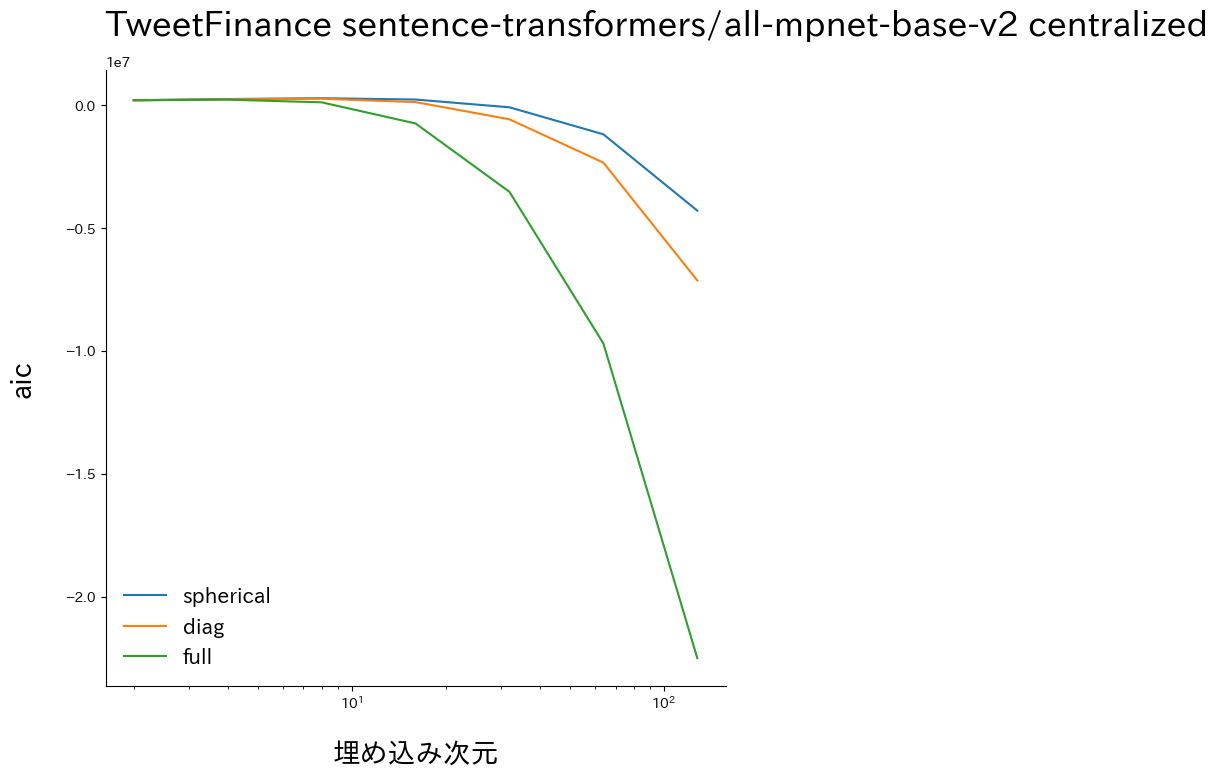

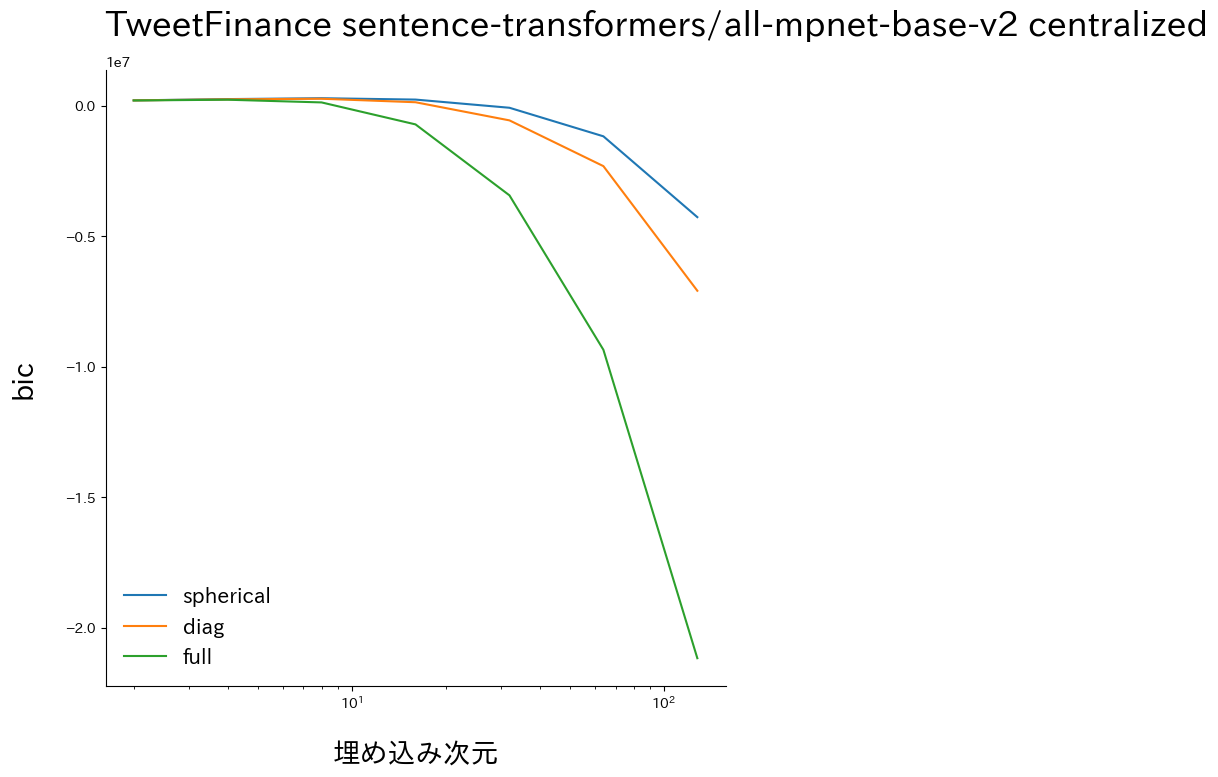

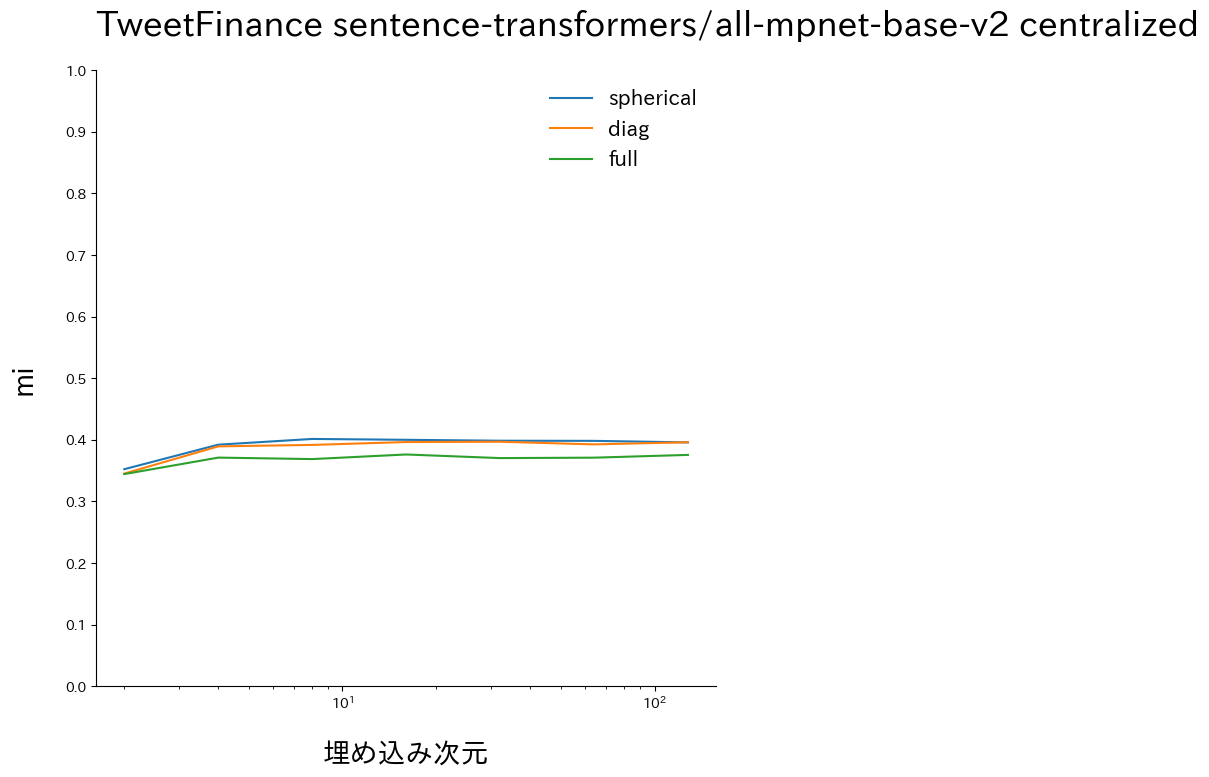

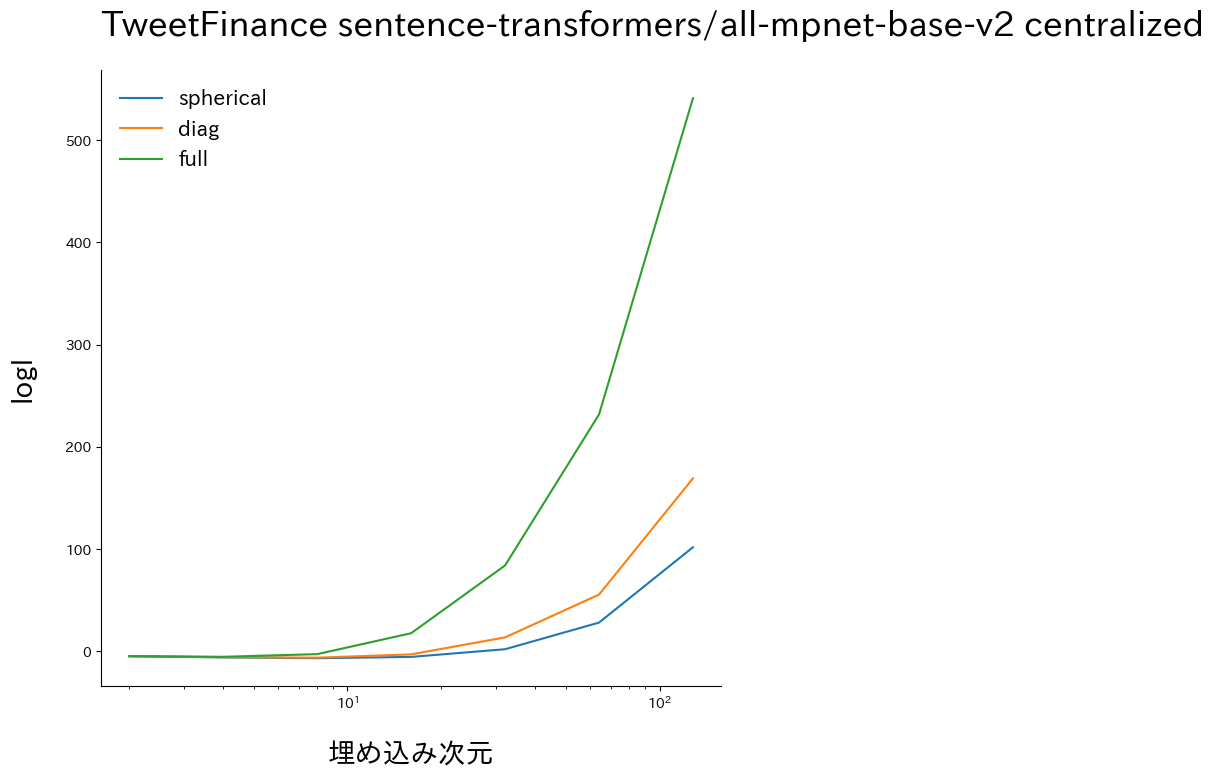

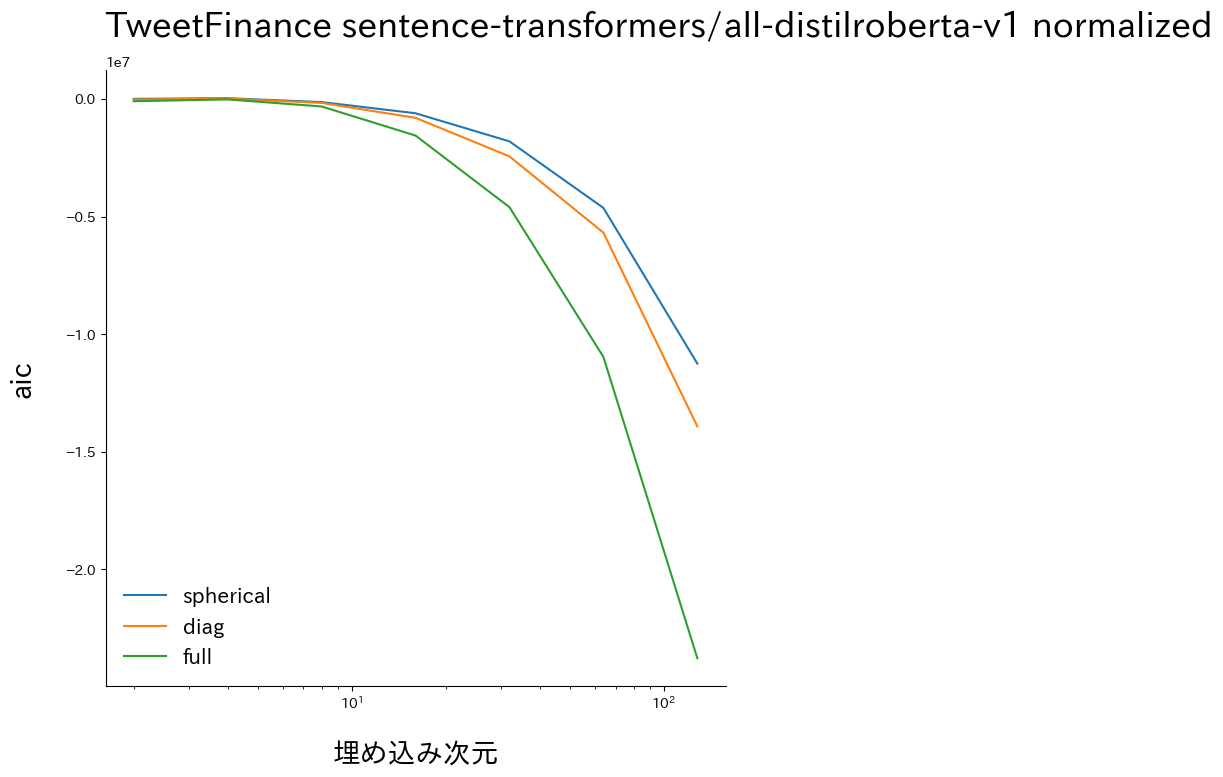

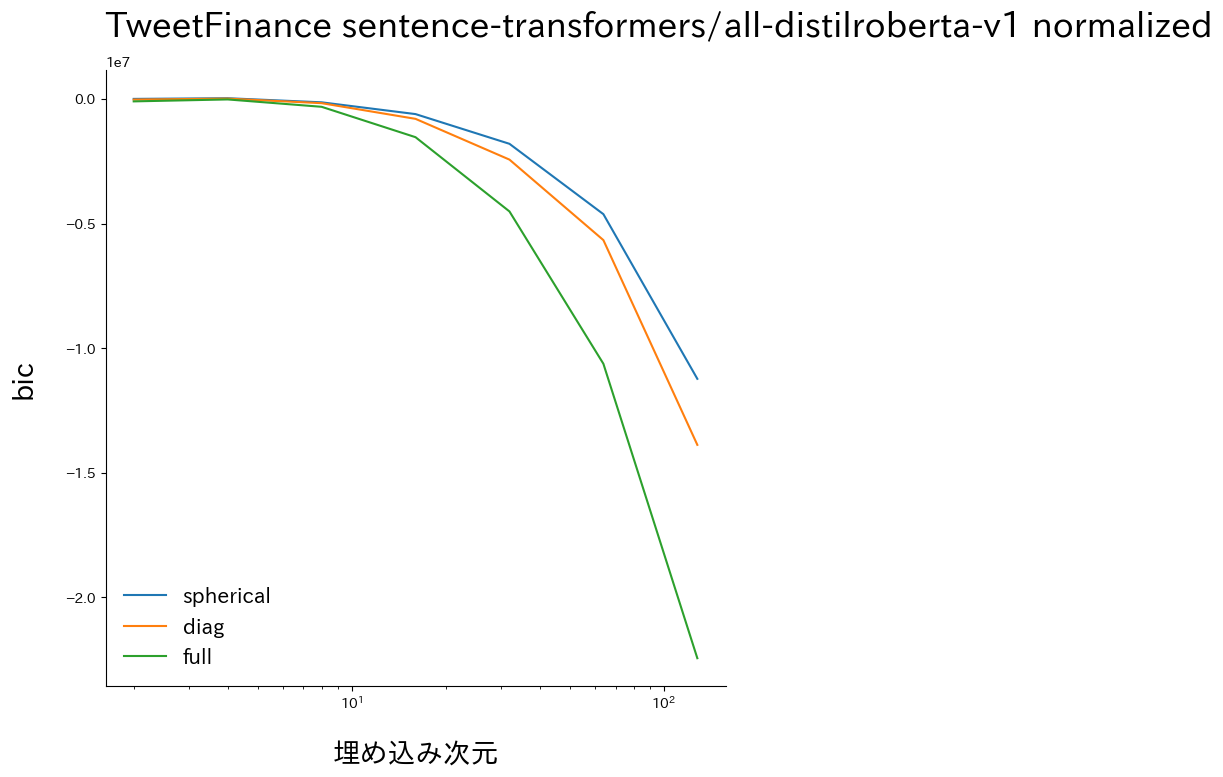

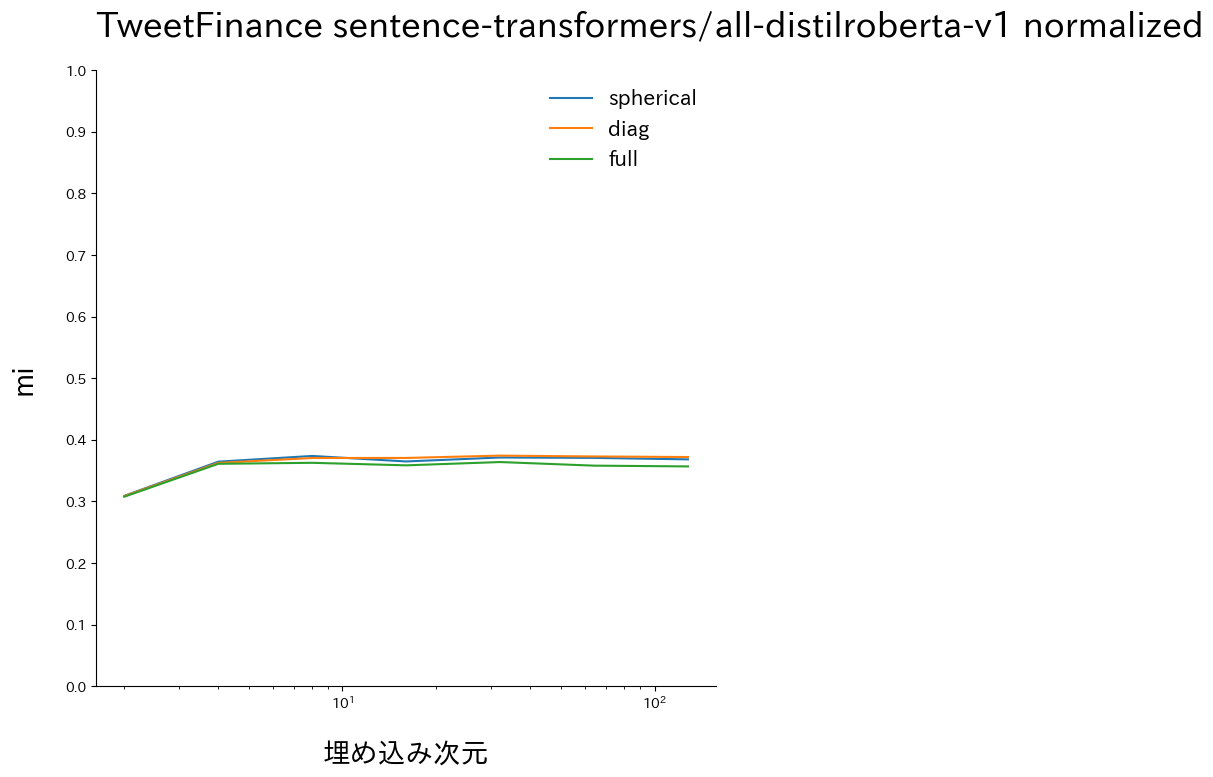

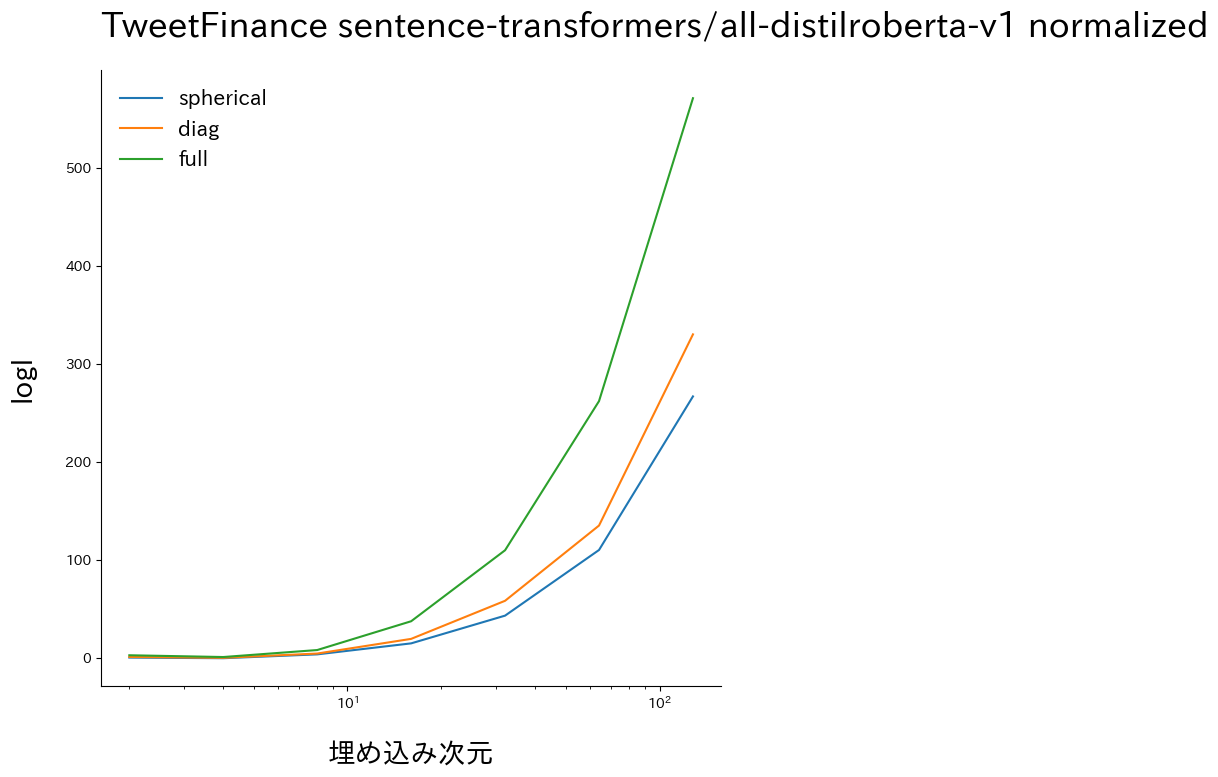

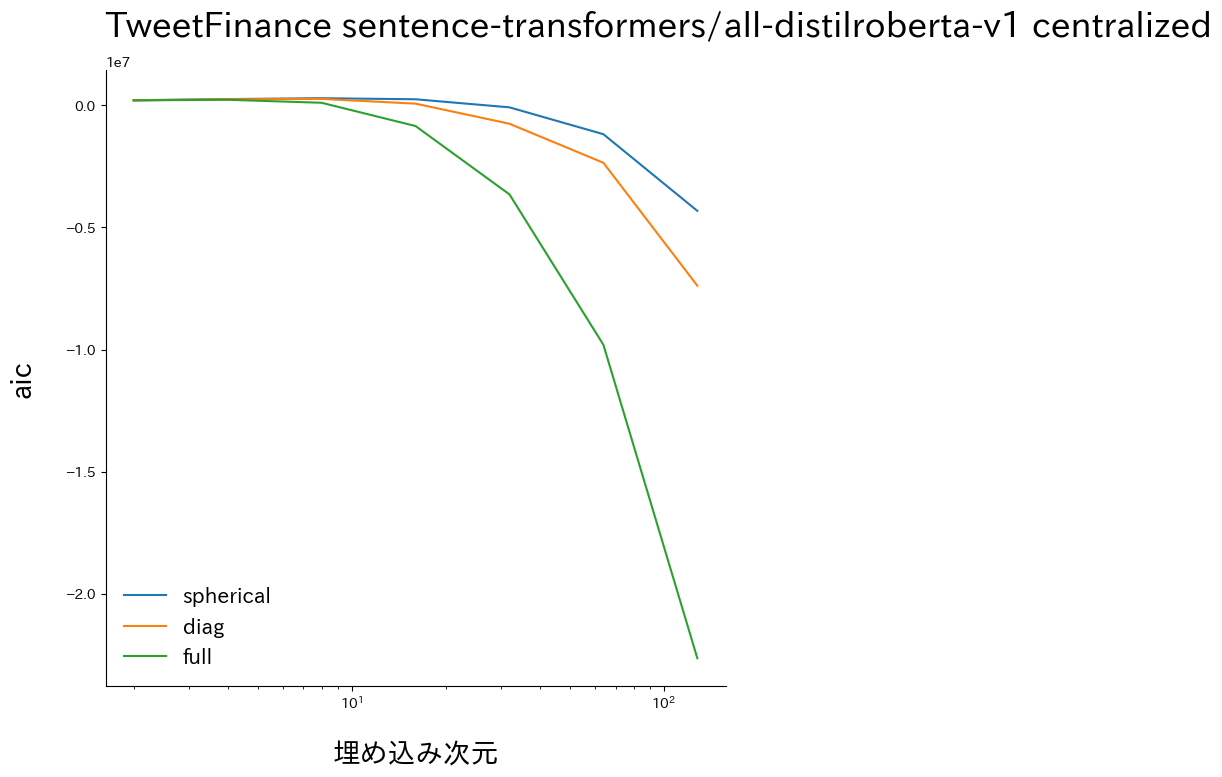

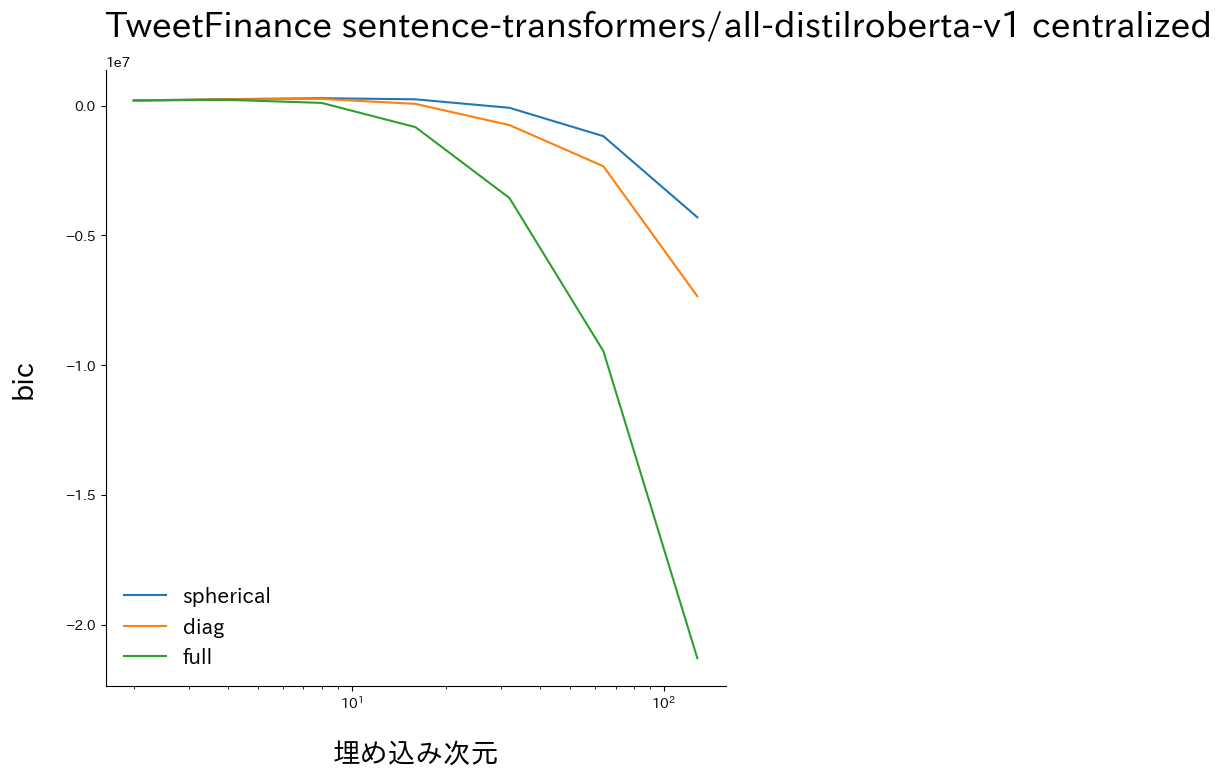

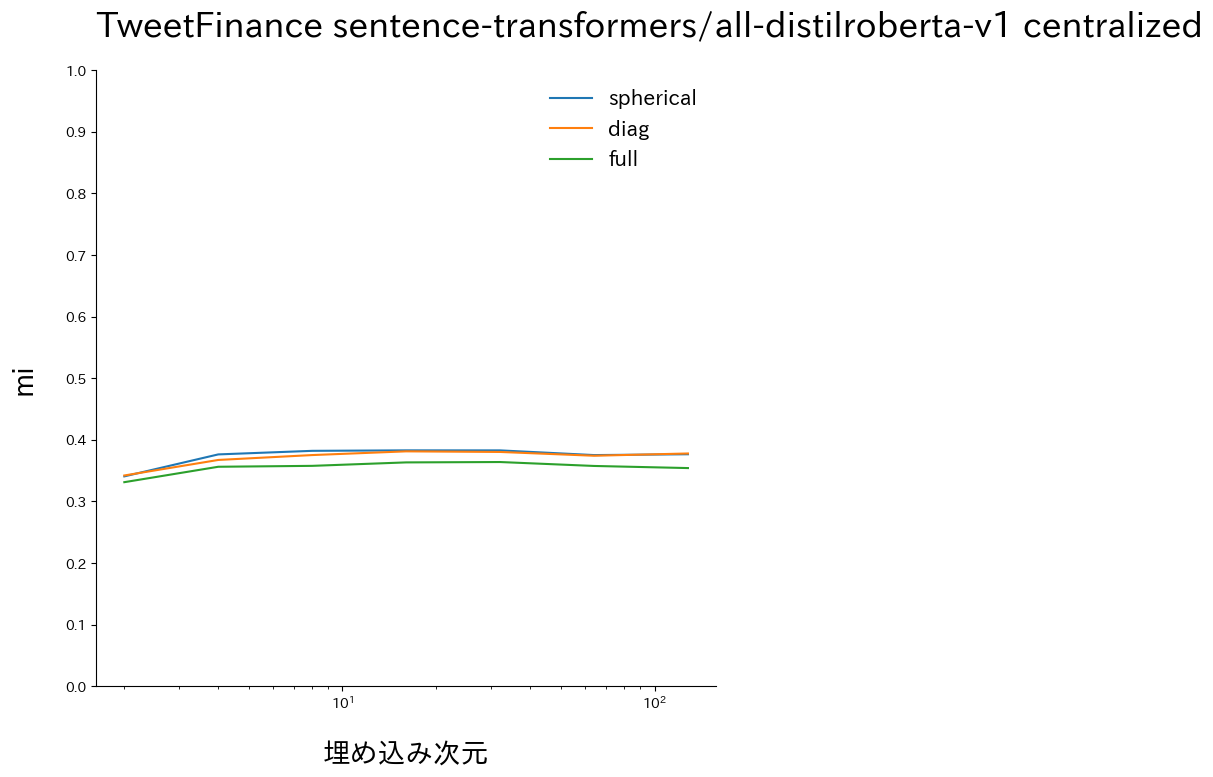

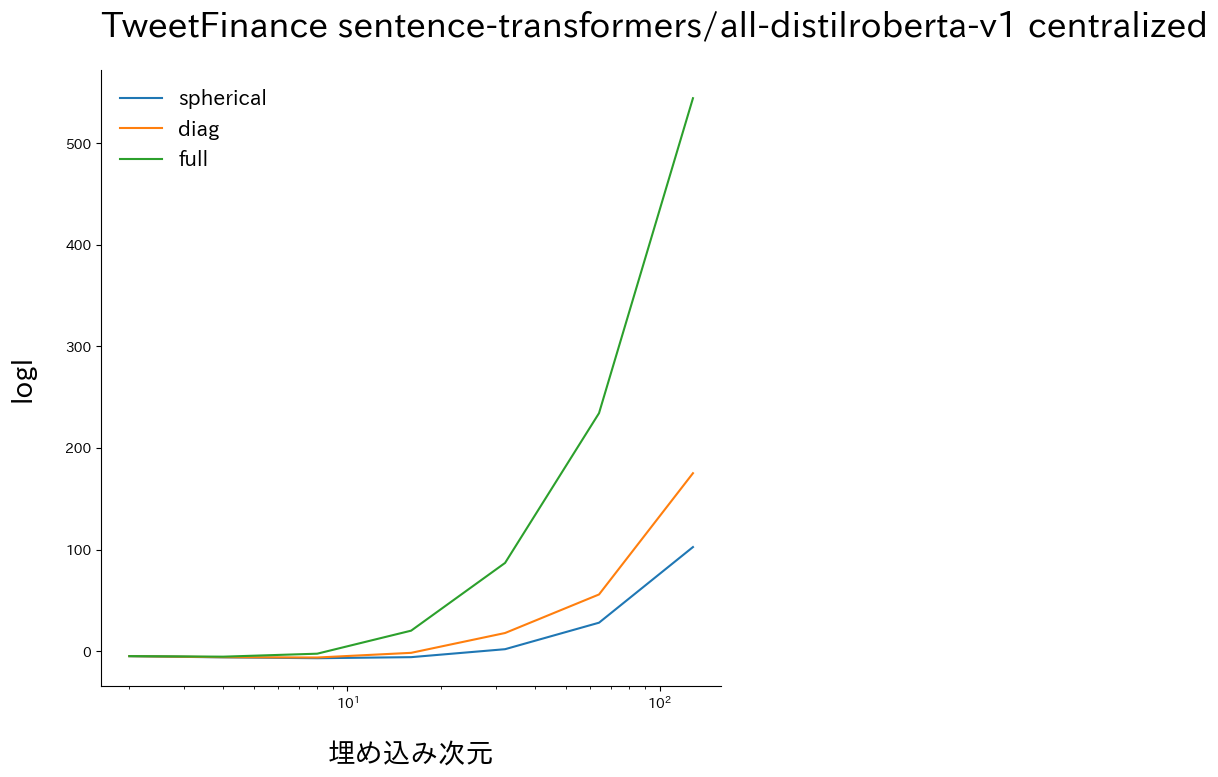

In [41]:
for key in product(*keys):
    fig = plt.figure(**layout["figure"])
    ax = fig.add_subplot(111)
    fig_path = f"/home/jovyan/temporary/Visualize/{data_type}/{vectorize_type}/{transformer_model}/temp.pdf"
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    title=f"{key[0]} {key[1]} {key[2]}"
    ax.set_xscale("log")
    
    for covariance_type in covariance_types:
        ax.plot(covariance_d.loc(key).loc[covariance_type, :], label=covariance_type)
        
    ax.set_title(title, **layout["title"])

    ax.set_xlabel(xlabel, **layout["label"])
    ax.set_ylabel(key[-1], **layout["label"])
    if key[-1] == "mi":
        ax.set_yticks(ticks=yticks, **layout["ticks"])
    ax.legend(**layout["legend"])

    fig.savefig(make_filepath(fig_path))

In [ ]:
multi_d.names_keys

In [42]:
multi_d = md.swap_keys(
    multi_d,
    [
        "transformer_model",
        "normalization",
        "vector_model_num",
        "covariance_type",
        "stats",
        "agg_type",
        "vector_dim",
        "data_type",
    ],
)

In [43]:
pd.DataFrame(
    multi_d.dictionary["sentence-transformers/all-MiniLM-L6-v2"]["normalized"][0][
        "full"
    ]["mi"]["mean"]
).style.highlight_max(axis=1)

,2,4,8,16,32,64,128
TweetTopic,0.404544,0.408512,0.405846,0.404961,0.414884,0.414134,0.409019
TweetFinance,0.302635,0.353142,0.345342,0.345383,0.339009,0.335845,0.336215


In [45]:
multi_d = md.swap_keys(
    multi_d,
    [
        "transformer_model",
        "vector_model_num",
        "covariance_type",
        "stats",
        "agg_type",
        "vector_dim",
        "normalization",
        "data_type",
    ],
)

In [46]:
pd.DataFrame(
    multi_d.dictionary["sentence-transformers/all-MiniLM-L6-v2"][0]["full"]["mi"][
        "mean"
    ][64]
).style.highlight_max(axis=1)

,normalized,centralized
TweetTopic,0.414134,0.388648
TweetFinance,0.335845,0.326888


In [47]:
multi_d = md.swap_keys(
    multi_d,
    [
        "transformer_model",
        "vector_model_num",
        "stats",
        "agg_type",
        "vector_dim",
        "normalization",
        "covariance_type",
        "data_type",
    ],
)

In [48]:
pd.DataFrame(
    multi_d.dictionary["sentence-transformers/all-MiniLM-L6-v2"][0]["mi"]["mean"][64][
        "centralized"
    ]
).style.highlight_max(axis=1)

,spherical,diag,full
TweetTopic,0.398265,0.397204,0.388648
TweetFinance,0.353395,0.351742,0.326888


In [49]:
multi_d = md.swap_keys(
    multi_d,
    [
        "vector_model_num",
        "stats",
        "agg_type",
        "vector_dim",
        "normalization",
        "covariance_type",
        "data_type",
        "transformer_model",
    ],
)

In [51]:
pd.DataFrame(
    multi_d.dictionary[0]["mi"]["mean"][64]["centralized"]["spherical"]
).style.highlight_max(axis=0)

,TweetTopic,TweetFinance
sentence-transformers/all-MiniLM-L6-v2,0.398265,0.353395
sentence-transformers/all-mpnet-base-v2,0.415366,0.398293
sentence-transformers/all-distilroberta-v1,0.411578,0.375212
